# Business Understanding

## Business Objective

## Executive Summary

# Data Engineering

## Import Libraries

In [111]:
# import libraries required to load, transform, analyze and plot data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline
import seaborn as sns
sns.set(context='paper', style='darkgrid', 
        rc={'figure.facecolor':'white'}, font_scale=1.2)
import boto3
import math

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_precision_recall_curve
from sklearn.metrics import make_scorer, precision_recall_curve, classification_report
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import roc_curve, auc, f1_score, roc_auc_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
import statsmodels.api as sm

In [2]:
# remove scientific notation and restrictions on df rows/columns display
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('display.max_colwidth', 150)

## Data Dictionary

## Dataframe Basics

In [3]:
# instantiate AWS s3 resource
s3 = boto3.resource('s3')

### Customers

In [4]:
# load customers dataframe
file_custs = 's3://sagemaker-studio-ueh1wh7idza/p05-olist-customer-rating-prediction/olist_customers_dataset.csv'
customers = pd.read_csv(file_custs, dtype={'customer_zip_code_prefix': str})
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,09790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,01151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,08775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
# check data types and nulls
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  object
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: object(5)
memory usage: 3.8+ MB


In [6]:
# check for duplicate customers
dups = customers[customers.duplicated(subset=['customer_id'])==True]
repeat = customers[customers.duplicated(subset=['customer_unique_id'])==True]
print(f'{dups.shape[0]} duplicate Customer_IDs found')
print(f'{repeat.shape[0]} repeat Unique_Customer_IDs found')

0 duplicate Customer_IDs found
3345 repeat Unique_Customer_IDs found


In [7]:
customers.describe()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
count,99441,99441,99441,99441,99441
unique,99441,96096,14994,4119,27
top,b95d13b18342b38a42c82dce122ab381,8d50f5eadf50201ccdcedfb9e2ac8455,22790,sao paulo,SP
freq,1,17,142,15540,41746


### Orders

In [8]:
# load orders dataframe
file_orders = 's3://sagemaker-studio-ueh1wh7idza/p05-olist-customer-rating-prediction/olist_orders_dataset.csv'
orders = pd.read_csv(file_orders, parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [9]:
# check data types and nulls
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [10]:
# check for duplicate orders
dups = orders[orders.duplicated(subset=['order_id'])==True]
print(f'{dups.shape[0]} duplicate Order_IDs found')

0 duplicate Order_IDs found


In [11]:
# check distribution of order status
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [12]:
# check distribution of order dates
orders.order_id.groupby([orders.order_purchase_timestamp.dt.year.rename('year'), orders.order_purchase_timestamp.dt.month.rename('month')]).size().reset_index(name='counts')

,year,month,counts
0,2016,9,4
1,2016,10,324
2,2016,12,1
3,2017,1,800
4,2017,2,1780
5,2017,3,2682
6,2017,4,2404
7,2017,5,3700
8,2017,6,3245
9,2017,7,4026


** Notes **
- Will limit final dataset to delivered status only
- Will limit purchases to complete periods 2017-01 through 2018-08 only

### Order Items

In [13]:
# load order items dataframe
file_order_items = 's3://sagemaker-studio-ueh1wh7idza/p05-olist-customer-rating-prediction/olist_order_items_dataset.csv'
order_items = pd.read_csv(file_order_items, parse_dates=['shipping_limit_date'])
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [14]:
# check data types and nulls
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [15]:
# check for duplicate orders
dups = order_items[order_items.duplicated(subset=['order_id', 'order_item_id'])==True]
print(f'{dups.shape[0]} duplicate Order_Item_IDs found')

0 duplicate Order_Item_IDs found


### Payments

In [16]:
# load payments dataframe
file_payments = 's3://sagemaker-studio-ueh1wh7idza/p05-olist-customer-rating-prediction/olist_order_payments_dataset.csv'
payments = pd.read_csv(file_payments)
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [17]:
# check data types and nulls
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [18]:
payments.order_id.groupby([payments.payment_type, payments.payment_installments]).size()

payment_type  payment_installments
boleto        1                       19784
credit_card   0                           2
              1                       25455
              2                       12413
              3                       10461
              4                        7098
              5                        5239
              6                        3920
              7                        1626
              8                        4268
              9                         644
              10                       5328
              11                         23
              12                        133
              13                         16
              14                         15
              15                         74
              16                          5
              17                          8
              18                         27
              20                         17
              21                         

In [19]:
# collapse installments and one-hot encode payments prior to merge
payments_ohe = pd.get_dummies(payments, columns = ['payment_type'])
payments_grp = payments_ohe.groupby(by=['order_id'], as_index=False).agg(pmt_tot=('payment_value', 'sum'), 
                                                                         pmt_cnt=('payment_sequential', 'count'), 
                                                                         pmt_boleto=('payment_type_boleto', 'max'),
                                                                         pmt_cc=('payment_type_credit_card', 'max'),
                                                                         pmt_voucher=('payment_type_voucher', 'max'),
                                                                         pmt_debit=('payment_type_debit_card', 'max')
                                                                        )
cols = ['pmt_cnt', 'pmt_boleto', 'pmt_cc', 'pmt_voucher', 'pmt_debit']
payments_grp[cols] = payments_grp[cols].astype('Int64')
payments_grp.describe()

,pmt_tot,pmt_cnt,pmt_boleto,pmt_cc,pmt_voucher,pmt_debit
count,"99,440.00","99,440.00","99,440.00","99,440.00","99,440.00","99,440.00"
mean,160.99,1.04,0.20,0.77,0.04,0.02
std,221.95,0.38,0.40,0.42,0.19,0.12
min,0.00,1.00,0.00,0.00,0.00,0.00
25%,62.01,1.00,0.00,1.00,0.00,0.00
50%,105.29,1.00,0.00,1.00,0.00,0.00
75%,176.97,1.00,0.00,1.00,0.00,0.00
max,"13,664.08",29.00,1.00,1.00,1.00,1.00


In [20]:
payments_grp.head()

,order_id,pmt_tot,pmt_cnt,pmt_boleto,pmt_cc,pmt_voucher,pmt_debit
0,00010242fe8c5a6d1ba2dd792cb16214,72.19,1,0,1,0,0
1,00018f77f2f0320c557190d7a144bdd3,259.83,1,0,1,0,0
2,000229ec398224ef6ca0657da4fc703e,216.87,1,0,1,0,0
3,00024acbcdf0a6daa1e931b038114c75,25.78,1,0,1,0,0
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04,1,0,1,0,0


In [21]:
# check for duplicate payment orders
dups = payments_grp[payments_grp.duplicated(subset=['order_id'])==True]
print(f'{dups.shape[0]} duplicate Order_IDs found on payments group')

0 duplicate Order_IDs found on payments group


### Products

In [22]:
# load products dataframe
file_products = 's3://sagemaker-studio-ueh1wh7idza/p05-olist-customer-rating-prediction/olist_products_dataset.csv'
products = pd.read_csv(file_products)
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.00,287.00,1.00,225.00,16.00,10.00,14.00
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.00,276.00,1.00,"1,000.00",30.00,18.00,20.00
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.00,250.00,1.00,154.00,18.00,9.00,15.00
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.00,261.00,1.00,371.00,26.00,4.00,26.00
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.00,402.00,4.00,625.00,20.00,17.00,13.00


In [23]:
# check data types and nulls
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [24]:
products['product_volume_cm'] = products.product_length_cm * products.product_height_cm * products.product_width_cm

In [25]:
products.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm
count,"32,341.00","32,341.00","32,341.00","32,949.00","32,949.00","32,949.00","32,949.00","32,949.00"
mean,48.48,771.50,2.19,"2,276.47",30.82,16.94,23.20,"16,564.10"
std,10.25,635.12,1.74,"4,282.04",16.91,13.64,12.08,"27,057.04"
min,5.00,4.00,1.00,0.00,7.00,2.00,6.00,168.00
25%,42.00,339.00,1.00,300.00,18.00,8.00,15.00,"2,880.00"
50%,51.00,595.00,1.00,700.00,25.00,13.00,20.00,"6,840.00"
75%,57.00,972.00,3.00,"1,900.00",38.00,21.00,30.00,"18,480.00"
max,76.00,"3,992.00",20.00,"40,425.00",105.00,105.00,118.00,"296,208.00"


### Product Category

In [26]:
# load product categories dataframe
file_product_cat = 's3://sagemaker-studio-ueh1wh7idza/p05-olist-customer-rating-prediction/product_category_name_translation.csv'
product_cat = pd.read_csv(file_product_cat)
product_cat.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [27]:
product_cat.describe()

,product_category_name,product_category_name_english
count,71,71
unique,71,71
top,seguros_e_servicos,music
freq,1,1


### Sellers

In [28]:
# load sellers dataframe
file_sellers = 's3://sagemaker-studio-ueh1wh7idza/p05-olist-customer-rating-prediction/olist_sellers_dataset.csv'
sellers = pd.read_csv(file_sellers, dtype={'seller_zip_code_prefix': str})
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,04195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [29]:
# check data types and nulls
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   object
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: object(4)
memory usage: 96.8+ KB


In [30]:
# describe sellers
sellers.describe()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
count,3095,3095,3095,3095
unique,3095,2246,611,23
top,4003520d80d0bad1d5623f7aa3c63cda,14940,sao paulo,SP
freq,1,49,694,1849


### Reviews

In [31]:
# load reviews dataframe
file_reviews = 's3://sagemaker-studio-ueh1wh7idza/p05-olist-customer-rating-prediction/olist_order_reviews_dataset_delim.csv'
reviews = pd.read_csv(file_reviews, parse_dates=['review_creation_date', 'review_answer_timestamp'])
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:00
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:00
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:00
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:00
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa,2018-03-01,2018-03-02 10:26:00


In [32]:
# check data types and nulls
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   review_id                100000 non-null  object        
 1   order_id                 100000 non-null  object        
 2   review_score             100000 non-null  int64         
 3   review_comment_title     11715 non-null   object        
 4   review_comment_message   41753 non-null   object        
 5   review_creation_date     100000 non-null  datetime64[ns]
 6   review_answer_timestamp  100000 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 5.3+ MB


In [33]:
# check for multiple reviews
print(f"{len(reviews[reviews.duplicated(subset=['order_id'], keep=False)].groupby('order_id'))} of {reviews.order_id.nunique()} orders with multiple reviews")

555 of 99441 orders with multiple reviews


In [34]:
# remove duplicate reviews from orders, retain latest only
latest = reviews.groupby('order_id')['review_id'].max()
reviews = pd.merge(left=latest, right=reviews, how='inner', left_on=['order_id','review_id'], right_on=['order_id','review_id'])

In [35]:
# check for multiple reviews
print(f"{len(reviews[reviews.duplicated(subset=['order_id'], keep=False)].groupby('order_id'))} of {reviews.order_id.nunique()} orders with multiple reviews")

0 of 99441 orders with multiple reviews


### Zip Geolocation

In [36]:
# load geolocation dataframe
geolocation = 's3://sagemaker-studio-ueh1wh7idza/p05-olist-customer-rating-prediction/olist_geolocation_dataset.csv'
geolocation_df = pd.read_csv(geolocation, dtype={'geolocation_zip_code_prefix': str})
zip_loc_lookup = geolocation_df.groupby('geolocation_zip_code_prefix').agg(zip_lat=('geolocation_lat', 'median'),
                               zip_long=('geolocation_lng', 'median')).reset_index()

In [37]:
# drop full geolocation frame
del geolocation_df

In [38]:
# create lat-long tuple for distance calcs, drop lat/long
zip_loc_lookup['zip_lat_long'] = tuple(zip(zip_loc_lookup.zip_lat, zip_loc_lookup.zip_long))
zip_loc_lookup.drop(columns=['zip_lat', 'zip_long'], inplace=True)
zip_loc_lookup.head()

,geolocation_zip_code_prefix,zip_lat_long
0,01001,"(-23.550380539269455, -46.634026997778314)"
1,01002,"(-23.548551065785627, -46.635072390789965)"
2,01003,"(-23.548976528997674, -46.635313112268456)"
3,01004,"(-23.549534948092827, -46.634770582289825)"
4,01005,"(-23.54961248124544, -46.636532025535224)"


## Merge Files

In [39]:
comp = pd.merge(left=orders, right=order_items, how='left', left_on='order_id', right_on='order_id', indicator=True)
comp.groupby(['order_status', '_merge'])['order_id'].count()

order_status  _merge    
approved      left_only          0
              right_only         0
              both               3
canceled      left_only        164
              right_only         0
              both             542
created       left_only          5
              right_only         0
              both               0
delivered     left_only          0
              right_only         0
              both          110197
invoiced      left_only          2
              right_only         0
              both             359
processing    left_only          0
              right_only         0
              both             357
shipped       left_only          1
              right_only         0
              both            1185
unavailable   left_only        603
              right_only         0
              both               7
Name: order_id, dtype: int64

**Note:** Given some orphan orders in order_items, going to enforce inner joins on merged dataset to ensure complete set of features for all rows. Also about 30 line item records drop due to nan product category. Accepting this as immaterial to keep features clean.

In [40]:
# combine and flatten tables
merged = pd.merge(left=orders, right=customers, how='inner', left_on='customer_id', right_on='customer_id')
merged = pd.merge(left=merged, right=order_items, how='inner', left_on='order_id', right_on='order_id')
merged = pd.merge(left=merged, right=products, how='inner', left_on='product_id', right_on='product_id')
merged = pd.merge(left=merged, right=product_cat, how='inner', left_on='product_category_name', right_on='product_category_name')
merged = pd.merge(left=merged, right=payments_grp, how='inner', left_on='order_id', right_on='order_id')
merged = pd.merge(left=merged, right=sellers, how='inner', left_on='seller_id', right_on='seller_id')
merged = pd.merge(left=merged, right=reviews, how='inner', left_on='order_id', right_on='order_id')

In [41]:
print(f'{order_items.shape[0]} rows in order_items lowest grain table')
print(f'{merged.shape[0]} rows in final inner joined merged df')

112650 rows in order_items lowest grain table
111020 rows in final inner joined merged df


In [42]:
# check order status distribution, only interested in delivered order reviews
merged.order_status.value_counts()

delivered      108635
shipped          1158
canceled          526
invoiced          347
processing        344
unavailable         7
approved            3
Name: order_status, dtype: int64

In [43]:
# filter merged df for delivered orders, continuous between 2017-01 and 2018-08
MONTH_START = '2017-01'
MONTH_END = '2018-08'
merged = merged[(merged.order_status=='delivered') & (merged.order_purchase_timestamp.dt.to_period('M') >= MONTH_START)
                & (merged.order_purchase_timestamp.dt.to_period('M') <= MONTH_END)]
print(f'{merged.shape[0]} rows in final filtered merged df')

108323 rows in final filtered merged df


In [44]:
# sort by order and line, and re-index, for ease of analysis
merged.sort_values(by=['order_id', 'order_item_id'], inplace=True)
merged.reset_index(drop=True, inplace=True)

In [45]:
# drop columns not required for analysis and modeling
merged.drop(columns=['customer_id', 'product_category_name', 'product_name_lenght', 'product_length_cm', 
                     'product_height_cm', 'product_width_cm','review_id', 'review_comment_title'], inplace=True)

In [46]:
# Check few rows of combined df
merged.tail()

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_description_lenght,product_photos_qty,product_weight_g,product_volume_cm,product_category_name_english,pmt_tot,pmt_cnt,pmt_boleto,pmt_cc,pmt_voucher,pmt_debit,seller_zip_code_prefix,seller_city,seller_state,review_score,review_comment_message,review_creation_date,review_answer_timestamp
108318,fffc94f6ce00a00581880bf54a75a037,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18,0c9aeda10a71f369396d0c04dce13a64,65077,sao luis,MA,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,"1,002.00",3.00,"10,150.00","53,400.00",housewares,343.40,1,1,0,0,0,88303,itajai,SC,5,NaN,2018-05-11,2018-05-14 12:53:00
108319,fffcd46ef2263f404302a634eb57f7eb,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01,0da9fe112eae0c74d3ba1fe16de0988b,81690,curitiba,PR,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,232.00,1.00,"8,950.00","44,460.00",computers_accessories,386.53,1,1,0,0,0,01206,sao paulo,SP,5,NaN,2018-07-24,2018-07-25 09:25:00
108320,fffce4705a9662cd70adb13d4a31832d,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10,cd79b407828f02fdbba457111c38e4c4,04039,sao paulo,SP,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,869.00,1.00,967.00,"9,576.00",sports_leisure,116.85,1,0,1,0,0,80610,curitiba,PR,5,NaN,2017-10-29,2017-10-29 21:33:00
108321,fffe18544ffabc95dfada21779c9644f,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25,eb803377c9315b564bdedad672039306,13289,vinhedo,SP,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,"1,306.00",1.00,100.00,"8,000.00",computers_accessories,64.71,1,0,1,0,0,04733,sao paulo,SP,5,Recebi o produto antes do prazo e corretamente.,2017-08-17,2017-08-18 12:24:00
108322,fffe41c64501cc87c801fd61db3f6244,delivered,2018-06-09 17:00:18,2018-06-09 17:10:13,2018-06-11 14:11:00,2018-06-14 17:56:26,2018-06-28,cd76a00d8e3ca5e6ab9ed9ecb6667ac4,18605,botucatu,SP,1,350688d9dc1e75ff97be326363655e01,f7ccf836d21b2fb1de37564105216cc1,2018-06-12 17:10:13,43.00,12.79,511.00,1.00,600.00,"1,710.00",bed_bath_table,55.79,1,0,1,0,0,14940,ibitinga,SP,5,NaN,2018-06-15,2018-06-17 21:27:00


## Data Cleaning

In [47]:
# check numeric column ranges
merged.describe()

,order_item_id,price,freight_value,product_description_lenght,product_photos_qty,product_weight_g,product_volume_cm,pmt_tot,pmt_cnt,pmt_boleto,pmt_cc,pmt_voucher,pmt_debit,review_score
count,"108,323.00","108,323.00","108,323.00","108,323.00","108,323.00","108,322.00","108,322.00","108,323.00","108,323.00","108,323.00","108,323.00","108,323.00","108,323.00","108,323.00"
mean,1.20,120.06,19.98,787.24,2.21,"2,095.41","15,216.33",179.72,1.04,0.20,0.77,0.04,0.01,4.07
std,0.71,182.11,15.74,651.31,1.72,"3,744.79","23,269.42",272.01,0.37,0.40,0.42,0.19,0.12,1.36
min,1.00,0.85,0.00,4.00,1.00,0.00,168.00,9.59,1.00,0.00,0.00,0.00,0.00,1.00
25%,1.00,39.90,13.08,348.00,1.00,300.00,"2,856.00",65.71,1.00,0.00,1.00,0.00,0.00,4.00
50%,1.00,74.90,16.29,603.00,1.00,700.00,"6,525.00",114.25,1.00,0.00,1.00,0.00,0.00,5.00
75%,1.00,134.90,21.16,986.00,3.00,"1,800.00","18,375.00",195.40,1.00,0.00,1.00,0.00,0.00,5.00
max,21.00,"6,735.00",409.68,"3,992.00",20.00,"40,425.00","296,208.00","13,664.08",26.00,1.00,1.00,1.00,1.00,5.00


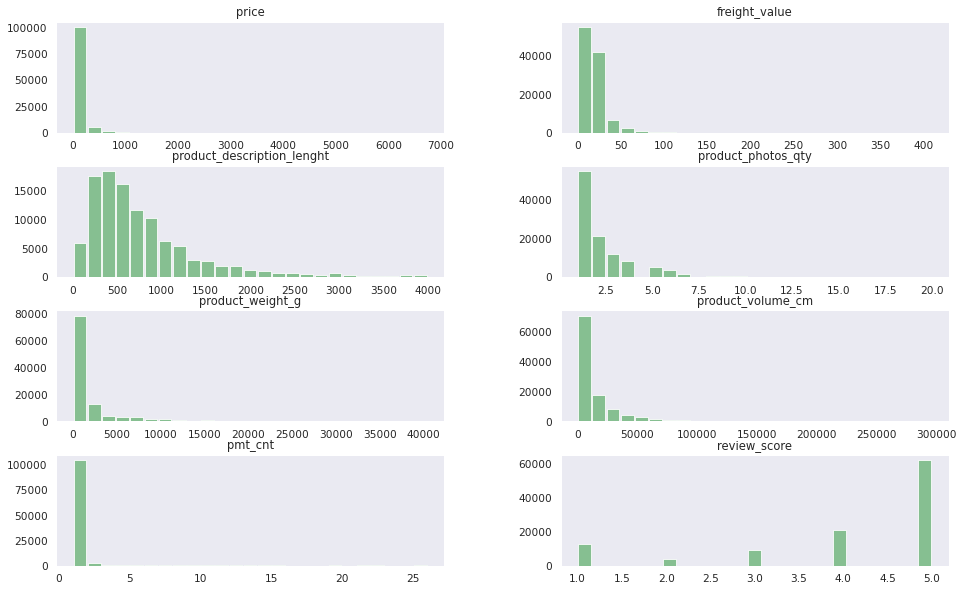

In [48]:
col_list = ['price', 'freight_value', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_volume_cm', 'pmt_cnt', 'review_score' ]

ax = merged.hist(column=col_list, bins=25, grid=False, figsize=(16, 10), layout=(4,2), sharex=False, color='#86bf91', zorder=2, rwidth=0.9)

In [49]:
# check value counts by column
col_list = ['order_status',  'customer_city', 'customer_state',  'product_category_name_english', 
'pmt_tot', 'pmt_cnt', 'pmt_boleto', 'pmt_cc', 'pmt_voucher', 'pmt_debit', 'seller_state', 'review_score']

for col in col_list:
     print(f'\nValue Counts | column = {col}')
     print(merged[col].value_counts(normalize=True, dropna=False))


Value Counts | column = order_status
delivered   1.00
Name: order_status, dtype: float64

Value Counts | column = customer_city
sao paulo                0.16
rio de janeiro           0.07
belo horizonte           0.03
brasilia                 0.02
curitiba                 0.02
                         ... 
bonito de santa fe       0.00
terra nova               0.00
riachuelo                0.00
breves                   0.00
alto alegre do pindare   0.00
Name: customer_city, Length: 4071, dtype: float64

Value Counts | column = customer_state
SP   0.42
RJ   0.13
MG   0.12
RS   0.06
PR   0.05
SC   0.04
BA   0.03
DF   0.02
GO   0.02
ES   0.02
PE   0.02
CE   0.01
PA   0.01
MT   0.01
MS   0.01
MA   0.01
PB   0.01
PI   0.00
RN   0.00
AL   0.00
SE   0.00
TO   0.00
RO   0.00
AM   0.00
AC   0.00
AP   0.00
RR   0.00
Name: customer_state, dtype: float64

Value Counts | column = product_category_name_english
bed_bath_table                            0.10
health_beauty                             

In [50]:
# check all columns for null values
for column in merged:
    if merged[column].isnull().any():
       print('{0} has {1} null values'.format(column, merged[column].isnull().sum()))

order_approved_at has 14 null values
order_delivered_carrier_date has 2 null values
order_delivered_customer_date has 8 null values
product_weight_g has 1 null values
product_volume_cm has 1 null values
review_comment_message has 62497 null values


In [51]:
# fill nan values where found
merged.fillna({'order_approved_at' : merged.order_purchase_timestamp, 
               'order_delivered_carrier_date' : merged.order_approved_at, 
               'order_delivered_customer_date': merged.order_estimated_delivery_date, 
               'product_volume_cm': merged.product_volume_cm.median(),
               'product_weight_g': merged.product_weight_g.median()}, inplace=True)

In [52]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108323 entries, 0 to 108322
Data columns (total 35 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       108323 non-null  object        
 1   order_status                   108323 non-null  object        
 2   order_purchase_timestamp       108323 non-null  datetime64[ns]
 3   order_approved_at              108323 non-null  datetime64[ns]
 4   order_delivered_carrier_date   108323 non-null  datetime64[ns]
 5   order_delivered_customer_date  108323 non-null  datetime64[ns]
 6   order_estimated_delivery_date  108323 non-null  datetime64[ns]
 7   customer_unique_id             108323 non-null  object        
 8   customer_zip_code_prefix       108323 non-null  object        
 9   customer_city                  108323 non-null  object        
 10  customer_state                 108323 non-null  object        
 11  

## Feature Engineering

### Review Bad Flag

In [53]:
# create bad review as 1 where score is 1/2
merged.insert(loc = merged.columns.get_loc('review_score')+1,
              column = 'review_bad',
              value = merged['review_score'].apply(lambda x: 1 if x in [1,2] else 0))

### Product/Seller Bad Review

In [54]:
# calculate seller and product average bad review %
seller_bad = merged.groupby('seller_id').agg(seller_bad_pct=('review_bad', 'mean')).reset_index()
merged = pd.merge(left=merged, right=seller_bad, how='inner', left_on='seller_id', right_on='seller_id')

product_bad = merged.groupby('product_id').agg(product_bad_pct=('review_bad', 'mean'), 
                                              product_order_cnt=('order_id', 'count')).reset_index()
merged = pd.merge(left=merged, right=product_bad, how='inner', left_on='product_id', right_on='product_id')

In [55]:
merged.head()

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_description_lenght,product_photos_qty,product_weight_g,product_volume_cm,product_category_name_english,pmt_tot,pmt_cnt,pmt_boleto,pmt_cc,pmt_voucher,pmt_debit,seller_zip_code_prefix,seller_city,seller_state,review_score,review_bad,review_comment_message,review_creation_date,review_answer_timestamp,seller_bad_pct,product_bad_pct,product_order_cnt
0,00010242fe8c5a6d1ba2dd792cb16214,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,598.00,4.00,650.00,"3,528.00",cool_stuff,72.19,1,0,1,0,0,27277,volta redonda,SP,5,0,"Perfeito, produto entregue antes do combinado.",2017-09-21,2017-09-22 10:57:00,0.12,0.11,9
1,130898c0987d1801452a8ed92a670612,delivered,2017-06-28 11:52:20,2017-06-29 02:44:11,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,jatai,GO,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.90,17.96,598.00,4.00,650.00,"3,528.00",cool_stuff,73.86,1,1,0,0,0,27277,volta redonda,SP,5,0,"lannister como sempre, entregou certinho e dentro do prazo. recomendo muito",2017-07-14,2017-07-17 12:50:00,0.12,0.11,9
2,532ed5e14e24ae1f0d735b91524b98b9,delivered,2018-05-18 10:25:53,2018-05-18 12:31:43,2018-05-23 14:05:00,2018-06-04 18:34:26,2018-06-07,3419052c8c6b45daf79c1e426f9e9bcb,30720,belo horizonte,MG,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.90,18.33,598.00,4.00,650.00,"3,528.00",cool_stuff,83.23,1,0,1,0,0,27277,volta redonda,SP,4,0,carrinho muito bonito,2018-06-05,2018-06-06 21:41:00,0.12,0.11,9
3,6f8c31653edb8c83e1a739408b5ff750,delivered,2017-08-01 18:38:42,2017-08-01 18:55:08,2017-08-02 19:07:36,2017-08-09 21:26:33,2017-08-25,e7c828d22c0682c1565252deefbe334d,83070,sao jose dos pinhais,PR,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.90,16.17,598.00,4.00,650.00,"3,528.00",cool_stuff,75.07,1,0,1,0,0,27277,volta redonda,SP,5,0,NaN,2017-08-10,2017-08-13 03:35:00,0.12,0.11,9
4,7d19f4ef4d04461989632411b7e588b9,delivered,2017-08-10 21:48:40,2017-08-10 22:05:11,2017-08-11 19:43:07,2017-08-24 20:04:21,2017-09-01,0bb98ba72dcc08e95f9d8cc434e9a2cc,36400,conselheiro lafaiete,MG,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.90,13.29,598.00,4.00,650.00,"3,528.00",cool_stuff,72.19,1,0,1,0,0,27277,volta redonda,SP,5,0,NaN,2017-08-25,2017-08-28 00:51:00,0.12,0.11,9


### Order Aggregate Measures

In [56]:
# create order-based aggregate measures
order_cnts = merged.groupby('order_id').agg(order_item_cnt=('product_id', 'count'),
                                            order_seller_cnt=('seller_id', 'nunique'),
                                            order_value=('price', 'sum'),
                                            order_freight=('freight_value', 'sum'),
                                            order_avg_price=('price', 'mean')).reset_index()

merged = pd.merge(left=merged, right=order_cnts, how='inner', left_on='order_id', right_on='order_id')
merged['order_freight_ratio'] = merged['freight_value'] / merged['order_value']

# check distribution on two dimensions
merged[['order_item_cnt','order_seller_cnt']].apply(pd.Series.value_counts)

,order_item_cnt,order_seller_cnt
1,85403,"105,313.00"
2,14526,"2,790.00"
3,3828,195.00
4,1952,12.00
5,935,13.00
6,1128,nan
7,154,nan
8,64,nan
9,27,nan
10,70,nan


### Order Intervals

In [57]:
# Calculate order interval features
merged['est_delivery_days'] = (merged.order_estimated_delivery_date - merged.order_purchase_timestamp).dt.days
merged['act_delivery_days'] = (merged.order_delivered_customer_date - merged.order_purchase_timestamp).dt.days
merged['days_variance'] = merged['act_delivery_days'] - merged['est_delivery_days']
merged['days_late'] = merged['days_variance'].map(lambda x: x if x > 0 else 0)
merged['is_late'] = merged['days_late'].map(lambda x: 1 if x > 0 else 0)
merged['pmt_approval_days'] = (merged.order_approved_at - merged.order_purchase_timestamp).dt.days
merged['order_hour_of_day'] = merged.order_purchase_timestamp.dt.hour
merged['order_day_of_week'] = merged.order_purchase_timestamp.dt.day_name()

### Delivery Distance Km

In [58]:
# append columns for customer lat-long values
merged = pd.merge(left=merged, right=zip_loc_lookup, how='left', left_on='customer_zip_code_prefix', 
                  right_on='geolocation_zip_code_prefix').rename(columns = {'zip_lat_long': 'cust_zip_lat_long'})

# drop extra zip code field
merged.drop(['geolocation_zip_code_prefix'], axis=1, inplace=True)

In [59]:
# append columns for seller lat-long values
merged = pd.merge(left=merged, right=zip_loc_lookup, how='left', left_on='seller_zip_code_prefix', 
                  right_on='geolocation_zip_code_prefix').rename(columns = {'zip_lat_long': 'sell_zip_lat_long'})

# drop extra zip code field
merged.drop(['geolocation_zip_code_prefix'], axis=1, inplace=True)

In [60]:
# dropping rows without proper geolocation details
print(f'{len(merged[(merged.sell_zip_lat_long.isnull()==True) | (merged.cust_zip_lat_long.isnull()==True)])} rows to be dropped without lat-long')
merged.drop(merged[(merged.sell_zip_lat_long.isnull()==True) | (merged.cust_zip_lat_long.isnull()==True)].index, inplace=True)

530 rows to be dropped without lat-long


In [61]:
def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [62]:
# create feature of miles from city center of Seattle
merged['delivery_km'] = merged.apply(lambda row: round(haversine(row['cust_zip_lat_long'], row['sell_zip_lat_long'])/1000, 0), axis=1).astype('Int64')

### One-Hot Encodes

In [63]:
# one-hot encode customer state variables
dow_dummies = pd.get_dummies(merged['order_day_of_week'], drop_first=False, prefix='o', dtype='int64')
state_dummies = pd.get_dummies(merged['customer_state'], drop_first=False, prefix='st', dtype='int64')

# concatenate OHE with original df
merged = pd.concat([merged, state_dummies, dow_dummies], axis=1)

### Time of Day Bins

In [64]:
# assign bins to hour of day
merged['tod_morning'] = merged['order_hour_of_day'].apply(lambda x: 1 if 6 <= x <= 11 else 0)
merged['tod_afternoon'] = merged['order_hour_of_day'].apply(lambda x: 1 if 12 <= x <= 17 else 0)
merged['tod_evening'] = merged['order_hour_of_day'].apply(lambda x: 1 if 18 <= x <= 23 else 0)
merged['tod_overnight'] = merged['order_hour_of_day'].apply(lambda x: 1 if 0 <= x <= 5 else 0)

### Drop Staging DF

In [65]:
# release staging data from memory prior to modeling
del customers
del orders
del order_items
del payments
del products
del product_cat
del sellers
del reviews
del zip_loc_lookup

## Train-Test Split

In [66]:
# list of non-predictive columns to remove from X
X_drops = ['review_bad', 'review_score', 'order_id', 'order_status', 'order_purchase_timestamp', 
           'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 
           'order_estimated_delivery_date', 'customer_unique_id', 'customer_zip_code_prefix', 
           'customer_city', 'customer_state', 'order_item_id', 'product_id', 'seller_id',
           'shipping_limit_date', 'product_category_name_english', 'seller_zip_code_prefix', 
           'seller_city', 'seller_state', 'review_comment_message', 'review_creation_date',
           'review_answer_timestamp', 'cust_zip_lat_long', 'sell_zip_lat_long', 
           'cust_zip_lat_long', 'sell_zip_lat_long', 'order_day_of_week', 'pmt_tot']

# Create X predictors and y target variable
y = merged['review_bad']
X = merged.drop(X_drops, axis=1)

# Split into training and test sets
SEED = 19
jobs = -1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED)

In [67]:
# fit scaler to training data and transform both train and test dataframes
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)                                 
X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)   

## Correlation

In [68]:
# create column correlation matrix
train_comb = pd.concat([X_train, y_train], axis=1)
corr = train_comb.corr()

# limit to bad review target and drop non-predictive fields
corr_badrev = corr.copy().loc[:, 'review_bad'].sort_values(ascending=False)
corr_badrev[(corr_badrev>=0.03) | (corr_badrev<=-0.03)]

review_bad             1.00
product_bad_pct        0.61
is_late                0.34
act_delivery_days      0.29
days_late              0.26
seller_bad_pct         0.26
days_variance          0.23
order_item_cnt         0.17
order_seller_cnt       0.15
order_freight          0.13
order_value            0.08
st_RJ                  0.07
est_delivery_days      0.05
delivery_km            0.05
freight_value          0.03
order_freight_ratio   -0.04
st_SP                 -0.06
Name: review_bad, dtype: float64

In [69]:
# check for collinearity among potential predictors by pairs
df = (corr
     .stack()
     .reset_index()
     .sort_values(0, ascending=False)
)
# zip the default name columns level_0 and level_1
df['pairs'] = list(zip(df.level_0, df.level_1))
# set index to pairs
df.set_index(['pairs'], inplace=True)
# now drop level columns
df.drop(columns=['level_1', 'level_0'], inplace=True)
# rename correlation column rather than 0
df.columns = ['correlation']
# drop duplicates and keep only pair correlations above 0.65
df.drop_duplicates(inplace=True)
df[abs(df.correlation) > .50]

,correlation
pairs,
"(price, price)",1.00
"(price, order_avg_price)",1.00
"(product_volume_cm, product_weight_g)",0.81
"(order_avg_price, order_value)",0.78
"(price, order_value)",0.78
"(tod_evening, order_hour_of_day)",0.76
"(days_late, act_delivery_days)",0.70
"(days_variance, days_late)",0.65
"(product_bad_pct, review_bad)",0.61


# Models


## Functions

### display_confusion()

In [70]:
# plot confusion matrix for classifier object
def display_confusion(model, X, y, labels=None):
    """Plots confusion matrix for a classifier model results

    Parameters:
    - model (classifier): model refit with best estimator during gridsearch
    - X (pd.DataFrame): independent X variables as input to model
    - y (array): y values (can be actual or predicted churn values)
    - labels (str): labels for predicted and actual values

    Returns: none
    """
    plot_confusion_matrix(model, X, y, cmap=plt.cm.Blues, 
                          display_labels=labels)
    plt.grid(False)     
    plt.tight_layout()
    plt.show()

### display_class_report()

In [71]:
# plot confusion matrix for classifier object
def display_class_report(y_true, y_hat):
    """Prints classification report for a classifier model predictions.

    Parameters:
    - y_true (pd.Series): true north y values (actual churn values)
    - y_hat (array): model predictions for y    

    Returns: none
    """
    print(pd.DataFrame(confusion_matrix(y_true, y_hat),
                       columns=['Not Bad Pred', 'Bad Review Pred'], 
                       index=['Not Bad Actual', 'Bad Review Actual']))
    print(classification_report(y_true, y_hat))

### drop_features()

In [72]:
# function drops columns not needed for model from dataframe
def drop_features(X_df, drop_list):
    """Drops list of columns on a dataframe prior to running a model. Can be
    used for training or test data.

    Parameters:
    - X_df (pd.DataFrame): dataframe containing all X features/columns
    - drop_list (list): columns to drop from X_df

    Returns:
    - X_df_tr (pd.DataFrame)
    """    
    X_df_tr = X_df.drop(drop_list, axis=1, inplace=False)
    return X_df_tr

### instantiate_grid()

In [73]:
# function to create standard gridsearchCV object
def instantiate_grid(model, grid_params, refit='precision'):
    """Creates a GridSearchCV object using estimator (model) applying grid 
    parameters and standard scoring metrics. 

    Parameters:
    - model (classifier): model estimator to use during grid search
    - grid_params (dict): lists of parameters for grid search iterations
    - refit (str): indicators scoring metric to refit best estimator

    Returns:
    - gs (object): GridSearchCV instantiation object
    """    
    # set common scoring metrics for use across models
    scoring = {'roc_auc': make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=False), 
               'accuracy': make_scorer(accuracy_score), 
               'precision': make_scorer(precision_score), 
               'recall': make_scorer(recall_score), 
               'f1': make_scorer(f1_score)
              }
    
    # GridSearch uses 5 cross-validation folds within each training iteration
    gs = GridSearchCV(estimator=model, param_grid=grid_params, verbose=3, 
                      scoring=scoring, refit=refit, 
                      cv=StratifiedKFold(n_splits=5, random_state=SEED, 
                                     shuffle=True))
    
    return gs

### show_grid_metrics()

In [74]:
# key metrics to evaluate model performance
def show_grid_metrics(cv_results, sort_by, top_n=10):
    """Extracts and displays top n sorted rows of evaluation metrics from 
    cross-validation results of a grid search.

    Parameters:
    - cv_results (DataFrame): full cross-validation results from grid search
    - sort_by (str): scoring metric to sort descending high-to-low
    - top_n (int): number of rows to display

    Returns:
    - cv_results_metrics (DataFrame): metrics for each model iteration
    """
    # define evaluation metrics to keep from cv results
    metrics = ['params', 'mean_test_roc_auc', 'mean_test_accuracy', 
               'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 
               'rank_test_roc_auc', 'rank_test_recall']

    cv_results_metrics = cv_results.loc[:, metrics]
    cv_results_metrics.sort_values(by=[sort_by], ascending=False, 
                                   inplace=True)
    display(cv_results_metrics[:top_n])
    return cv_results_metrics

### feature_importance()

In [75]:
#
def feature_importance(model, X_df):
    """Extracts and plots relative feature importance based on classifier
    model coefficients.

    Parameters:
    - model (classifier): model estimator to use during grid search
    - X_df (pd.DataFrame): dataframe containing all X features/columns

    Returns:
    - coef_table (DataFrame): coefficient table by feature
    """    
    # create feature coefficient dataframe
    coef_table = pd.DataFrame(X_df.columns, columns=['feature'])
    coef_table.insert(1, 'coef', model.coef_.transpose())

    # plot feature coefficient on bar graph
    fig = plt.figure(figsize=(18, 8))
    sns.barplot(x='feature', y='coef', data=coef_table, palette='vlag')
    plt.title('Model Coefficients by Feature', size=20)
    plt.xlabel('Feature', size=16)
    plt.ylabel('Model Coefficient', size=16)
    plt.xticks(rotation=-80)
    plt.tight_layout()
    plt.show()
    
    return coef_table

### score_pred()

In [76]:
# calculates model evaluation metrics by comparing predictions to "true north"
def score_pred(model_type, data_type, y_true, y_hat):
    """Calculates and returns ROC AUC, accuracy, recall, precision, f1 score; 
    prints compact results summary.

    Parameters:
    - model_type (str): identifes type of model (eg. 'rf' = random forest)
    - data_type (str): indicates if y values are from train or test results
    - y_true (pd.Series): true north y values (actual churn values)
    - y_hat (array): model predictions for y

    Returns:
    - scores (dict): includes 5 evaluation metrics for model type
    """
    scores = {}
    scores['model'] = model_type
    scores['data'] = data_type
    scores['auc'] = roc_auc_score(y_true, y_hat)
    scores['acc'] = accuracy_score(y_true, y_hat)
    scores['rec'] = recall_score(y_true, y_hat)
    scores['prec'] = precision_score(y_true, y_hat)
    scores['f1'] = f1_score(y_true, y_hat)   
    print(f'Model {scores["model"]} Predictions: AUC {round(scores["auc"], 2)} | '
          f'Accuracy {round(scores["acc"], 2)} | '
          f'Recall {round(scores["rec"], 2)} | '
          f'Precision {round(scores["prec"], 2)} | '
          f'F1 {round(scores["f1"], 2)}' )

    return scores

### assign_class()

In [77]:
def assign_class(y_hat_prob, dt=0.5):
    """
    Calculates churn predictions based on any decision threshold level 
    using a classification model's predicted probability scores.
    
    Parameters:
    - y_hat_prob (array): predicted churn probabilities
    - dt (float): decision threshold value between 0 and 1. Represents 
      predicted probability at which postive class (churn) should be assigned.

    Returns:
    - scores (dict): includes 5 evaluation metrics for model type
    """
    return [1 if y >= dt else 0 for y in y_hat_prob]

### plot_pr_curve()

In [78]:
def plot_pr_curve(p, r, thresholds, model_type, dt=[0.5]):
    """
    Plots the precision-recall curve indicating the current values for a
    classifier decision threshold. Default classifier models use >= 0.5.
   
    Parameters:
    - p (array): precision value at certain threshold
    - r (array): recall value at certain threshold
    - thresholds (array): probability threshold where positive class is assigned
    - dt (float): decision threshold value between 0 and 1. Represents 
      desired probability at which postive class (bad review) should be assigned.
    - model_type (str): Text for model type title

    Returns: None
    """
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title(f'{model_type} | Precision-Recall Curve | Shows Decision Thresholds')
    plt.step(r, p, color='b', alpha=0.2, where='post')
    plt.fill_between(r, p, step='post', alpha=0.2, color='b')
    plt.ylim([0, 1.01])
    plt.xlim([0, 1.01])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    # plot the current threshold on the line
    for t in dt:
        dt_point = np.argmin(np.abs(thresholds - t))
        dt_label = 'DT = '+str(t)
        plt.plot(r[dt_point], p[dt_point], 'o', c='k', markersize=12)
        plt.annotate(dt_label, 
                     (r[dt_point], p[dt_point]),
                     textcoords="offset points", 
                     xytext=(0,12), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center


### plot_pr_vs_dt()

In [79]:
def plot_pr_vs_dt(p, r, thresholds, model_type):
    """
    Plots precision and recall lines (y) for each value of classifier decision
    threshold (x). Default classifier models use >= 0.5.
   
    Parameters:
    - p (array): precision value at certain threshold
    - r (array): recall value at certain threshold
    - thresholds (array): probability threshold where positive class is assigned
    - model_type (str): Text for model type title

    Returns: None
    """
    plt.figure(figsize=(8, 8))
    plt.title(f'{model_type} | Precision-Recall Scores vs. Decision Threshold')
    plt.plot(thresholds, p[:-1], 'b--', label='Precision')
    plt.plot(thresholds, r[:-1], 'g-', label='Recall')
    plt.ylabel('Score')
    plt.xlabel('Decision Threshold')
    plt.legend(loc='best')

### plot_roc_curve()

In [80]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

## Dummy Model (m0)

In [79]:
# establish dummy model and score accuracy
dum = DummyClassifier(strategy='stratified')
dum.fit(X_train, y_train)
y_hat_train_m0 = dum.predict(X_train)
print(f'Dummy Model Accuracy: {round(dum.score(y_train, y_hat_train_m0), 2)}')

Dummy Model Accuracy: 0.74


In [80]:
# compare Dummy Model metrics for Train vs Test data sets
print('Train Performance - Dummy Model\n---------------------------------')
y_hat_train0 = dum.predict(X_train)
scores_train_dum = score_pred('dum', 'train', y_train, y_hat_train0)

print('\nTest Performance - Dummy Model\n--------------------------------')
y_hat_test0 = dum.predict(X_test)
scores_test_dum = score_pred('dt', 'test', y_test, y_hat_test0)

Train Performance - Dummy Model
---------------------------------
Model dum Predictions: AUC 0.5 | Accuracy 0.74 | Recall 0.15 | Precision 0.15 | F1 0.15

Test Performance - Dummy Model
--------------------------------
Model dt Predictions: AUC 0.5 | Accuracy 0.74 | Recall 0.15 | Precision 0.15 | F1 0.15


## Random Forest (m2)

In [81]:
# create Random Forest classifier object
model_rf = RandomForestClassifier(random_state=SEED, n_jobs=jobs)

In [82]:
# define the grid for Random Forest
grid_params_rf = [{'criterion': ['gini', 'entropy'], # measures split quality
                   'class_weight': [None, 'balanced'], # adjust imbalanced positive class
                   'n_estimators': [100, 500], # number trees to grow            
                   'max_features': ['auto', None], # features considered at splits
                   'max_depth': [3, 5, 8],  # max nodes in each tree
                   'min_samples_leaf': [10, 25] # samples required in each leaf
                    }]

In [83]:
# create gridsearchCV object for Random Forest
gs_rf = instantiate_grid(model_rf, grid_params_rf)

In [84]:
# execute the Random Forest gridsearchCV on training data
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END class_weight=None, criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=10, n_estimators=100; accuracy: (test=0.879) f1: (test=0.371) precision: (test=0.855) recall: (test=0.237) roc_auc: (test=0.615) total time=   1.7s
[CV 2/5] END class_weight=None, criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=10, n_estimators=100; accuracy: (test=0.880) f1: (test=0.378) precision: (test=0.864) recall: (test=0.242) roc_auc: (test=0.617) total time=   0.7s
[CV 3/5] END class_weight=None, criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=10, n_estimators=100; accuracy: (test=0.876) f1: (test=0.344) precision: (test=0.844) recall: (test=0.216) roc_auc: (test=0.605) total time=   0.6s
[CV 4/5] END class_weight=None, criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=10, n_estimators=100; accuracy: (test=0.878) f1: (test=0.370) precision: (test=0.839) recall: (test=0.237)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=19, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=19),
             param_grid=[{'class_weight': [None, 'balanced'],
                          'criterion': ['gini', 'entropy'],
                          'max_depth': [3, 5, 8],
                          'max_features': ['auto', None],
                          'min_samples_leaf': [10, 25],
                          'n_estimators': [100, 500]}],
             refit='precision',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)},
             verbose=3)

In [112]:
# print confusion matrix (train) for best model
best_model_rf = gs_rf.best_estimator_
print('Random Forest Confusion Matrix - Training Data')
display_confusion(best_model_rf, X_train, y_train, labels=['Not Bad', 'Bad Review'])
print(f'Best Model Parameters: {gs_rf.best_index_} {gs_rf.best_params_}')

NameError: name 'gs_rf' is not defined

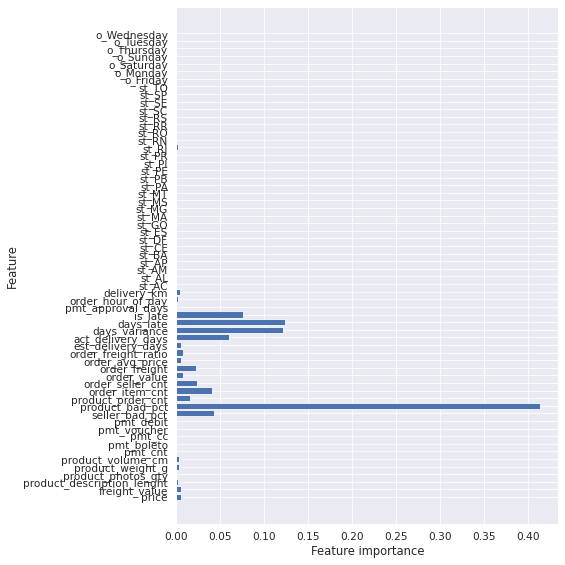

In [86]:
# plot Random Forest feature importance for best estimator
n_features = X_train.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), best_model_rf.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [87]:
# np.concatenate((best_model_rf.feature_importances_, X_train.columns.values))
# dataset = pd.DataFrame({'feature': X_train.columns.values, 'importance': best_model_rf.feature_importances_}, columns=['feature', 'importance'])
# feature_importances = pd.DataFrame(best_model_rf.feature_importances_, index=best_model_rf.columns, columns=['importance']).sort_values('importance', ascending=False)

In [88]:
# display top model results
cv_results2 = pd.DataFrame.from_dict(gs_rf.cv_results_)
cv_results_metrics2 = show_grid_metrics(cv_results2, 'mean_test_precision', top_n=5)

,params,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,rank_test_roc_auc,rank_test_recall
17,"{'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 10, 'n_estimators': 500}",0.74,0.92,0.89,0.50,0.64,65,65
19,"{'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 25, 'n_estimators': 500}",0.74,0.91,0.89,0.50,0.64,66,66
18,"{'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 25, 'n_estimators': 100}",0.74,0.91,0.89,0.48,0.63,68,68
16,"{'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 10, 'n_estimators': 100}",0.74,0.91,0.89,0.50,0.64,67,67
31,"{'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 25, 'n_estimators': 500}",0.72,0.91,0.88,0.45,0.59,75,75


In [89]:
# compare Random Forest metrics for Train vs Test data sets
print('Train Performance - Random Forest\n---------------------------------')
y_hat_train2 = gs_rf.predict(X_train)
scores_train_rf = score_pred('rf', 'train', y_train, y_hat_train2)

print('\nTest Performance - Random Forest\n--------------------------------')
y_hat_test2 = gs_rf.predict(X_test)
scores_test_rf = score_pred('rf', 'test', y_test, y_hat_test2)

Train Performance - Random Forest
---------------------------------
Model rf Predictions: AUC 0.75 | Accuracy 0.92 | Recall 0.51 | Precision 0.9 | F1 0.65

Test Performance - Random Forest
--------------------------------
Model rf Predictions: AUC 0.74 | Accuracy 0.91 | Recall 0.48 | Precision 0.89 | F1 0.62


Random Forest Confusion Matrix - Test Data


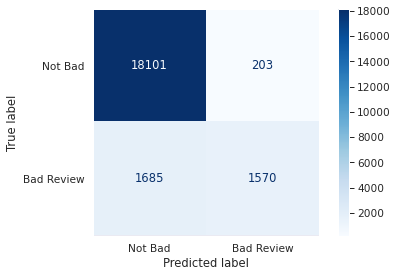

                   Not Bad Pred  Bad Review Pred
Not Bad Actual            18101              203
Bad Review Actual          1685             1570
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     18304
           1       0.89      0.48      0.62      3255

    accuracy                           0.91     21559
   macro avg       0.90      0.74      0.79     21559
weighted avg       0.91      0.91      0.90     21559



In [90]:
# print confusion matrix for best Random Forest model on Test data
print(f'Random Forest Confusion Matrix - Test Data')
display_confusion(best_model_rf, X_test, y_test, labels=['Not Bad', 'Bad Review'])
display_class_report(y_test, y_hat_test2)

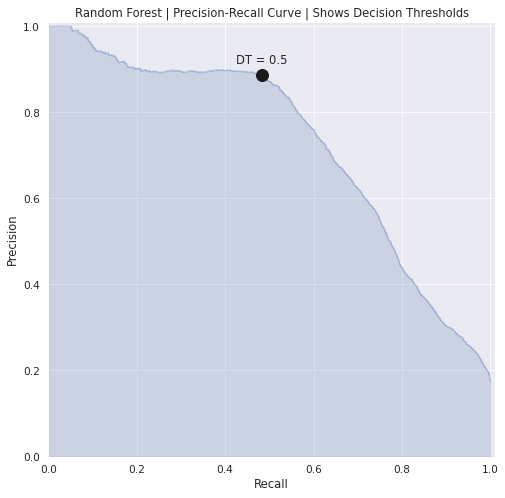

In [93]:
# generate Random Forest predict probabilities; store precision-recall curve values
y_hat_prob_test2 = best_model_rf.predict_proba(X_test)[:, 1]
p2, r2, thresholds2 = precision_recall_curve(y_test, y_hat_prob_test2)

# plot precision-recall curve for baseline decision threshold 0.5
plot_pr_curve(p2, r2, thresholds2, 'Random Forest', dt=[0.5])

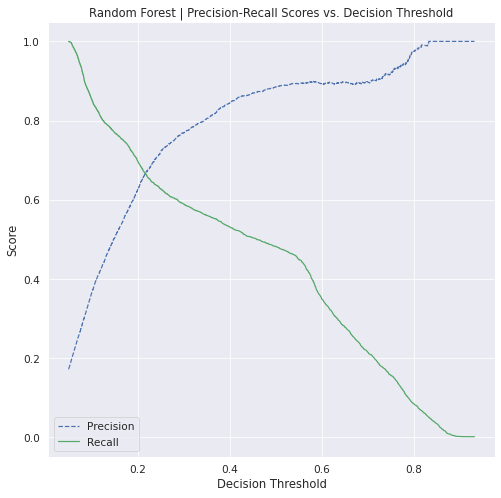

In [92]:
# plot precision and recall against decision threshold options
plot_pr_vs_dt(p2, r2, thresholds2, 'Random Forest')

## AdaBoost (m3)

In [78]:
# create AdaBoost classifier object
model_ab = AdaBoostClassifier(tree.DecisionTreeClassifier(random_state=SEED), random_state=SEED)

In [79]:
# define the grid for AdaBoost
grid_params_ab = [{'n_estimators': [100, 500],
                   'learning_rate': [0.01, 0.1, 1],
                   'base_estimator__criterion' : ['gini', 'entropy'],
                   'base_estimator__max_depth': [3, 5, 8]
                  }]

In [80]:
# create gridsearchCV object for AdaBoost
gs_ab = instantiate_grid(model_ab, grid_params_ab)

In [ ]:
# execute the AdaBoost gridsearchCV on training data
gs_ab.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END base_estimator__criterion=gini, base_estimator__max_depth=3, learning_rate=0.01, n_estimators=100; accuracy: (test=0.914) f1: (test=0.647) precision: (test=0.852) recall: (test=0.522) roc_auc: (test=0.753) total time=  24.9s
[CV 2/5] END base_estimator__criterion=gini, base_estimator__max_depth=3, learning_rate=0.01, n_estimators=100; accuracy: (test=0.914) f1: (test=0.651) precision: (test=0.848) recall: (test=0.528) roc_auc: (test=0.755) total time=  24.9s
[CV 3/5] END base_estimator__criterion=gini, base_estimator__max_depth=3, learning_rate=0.01, n_estimators=100; accuracy: (test=0.914) f1: (test=0.644) precision: (test=0.858) recall: (test=0.515) roc_auc: (test=0.750) total time=  25.0s
[CV 4/5] END base_estimator__criterion=gini, base_estimator__max_depth=3, learning_rate=0.01, n_estimators=100; accuracy: (test=0.916) f1: (test=0.659) precision: (test=0.849) recall: (test=0.539) roc_auc: (test=0.761) total

AdaBoost Confusion Matrix - Training Data


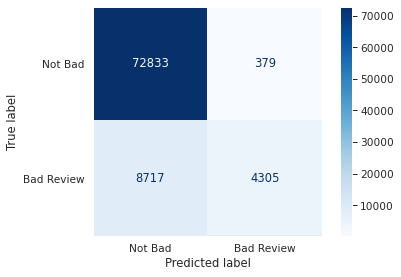

Best Model Parameters: 0 {'learning_rate': 0.01, 'n_estimators': 100}


In [110]:
# print confusion matrix (train) for best model
best_model_ab = gs_ab.best_estimator_
print('AdaBoost Confusion Matrix - Training Data')
display_confusion(best_model_ab, X_train, y_train, labels=['Not Bad', 'Bad Review'])
print(f'Best Model Parameters: {gs_ab.best_index_} {gs_ab.best_params_}')

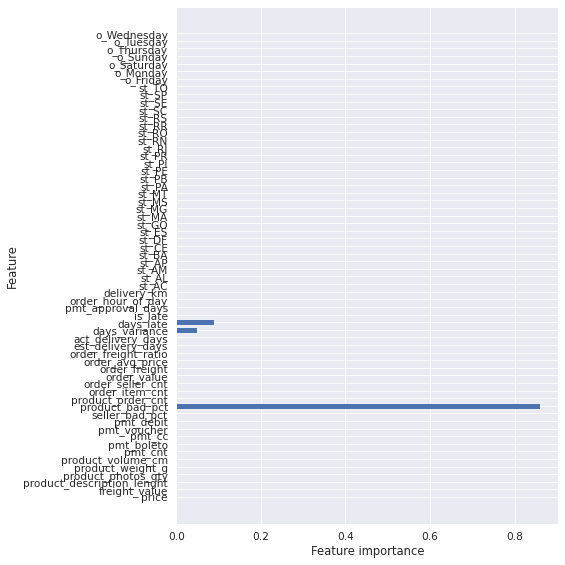

In [111]:
# plot AdaBoost feature importance for best estimator
n_features = X_train.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), best_model_ab.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [112]:
# display top model results
cv_results3 = pd.DataFrame.from_dict(gs_ab.cv_results_)
cv_results_metrics3 = show_grid_metrics(cv_results3, 'mean_test_precision', top_n=5)

,params,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,rank_test_roc_auc,rank_test_recall
0,"{'learning_rate': 0.01, 'n_estimators': 100}",0.66,0.89,0.92,0.33,0.49,6,6
1,"{'learning_rate': 0.01, 'n_estimators': 500}",0.74,0.91,0.90,0.48,0.63,5,5
2,"{'learning_rate': 0.1, 'n_estimators': 100}",0.76,0.92,0.86,0.53,0.66,4,4
3,"{'learning_rate': 0.1, 'n_estimators': 500}",0.77,0.92,0.85,0.55,0.67,3,3
5,"{'learning_rate': 1, 'n_estimators': 500}",0.77,0.92,0.83,0.57,0.67,1,1


In [113]:
# compare AdaBoost metrics for Train vs Test data sets
print('Train Performance - AdaBoost\n---------------------------------')
y_hat_train3 = gs_ab.predict(X_train)
scores_train_ab = score_pred('ab', 'train', y_train, y_hat_train3)

print('\nTest Performance - AdaBoost\n--------------------------------')
y_hat_test3 = gs_ab.predict(X_test)
scores_test_ab = score_pred('ab', 'test', y_test, y_hat_test3)

Train Performance - AdaBoost
---------------------------------
Model ab Predictions: AUC 0.66 | Accuracy 0.89 | Recall 0.33 | Precision 0.92 | F1 0.49

Test Performance - AdaBoost
--------------------------------
Model ab Predictions: AUC 0.66 | Accuracy 0.89 | Recall 0.32 | Precision 0.92 | F1 0.47


AdaBoost Confusion Matrix - Test Data


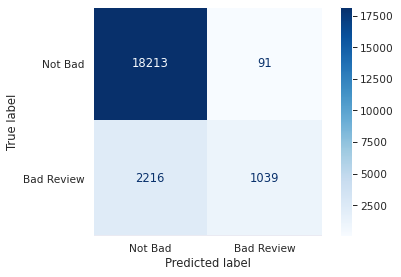

                   Not Bad Pred  Bad Review Pred
Not Bad Actual            18213               91
Bad Review Actual          2216             1039
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18304
           1       0.92      0.32      0.47      3255

    accuracy                           0.89     21559
   macro avg       0.91      0.66      0.71     21559
weighted avg       0.90      0.89      0.87     21559



In [114]:
# print confusion matrix for best AdaBoost model on Test data
print(f'AdaBoost Confusion Matrix - Test Data')
display_confusion(best_model_ab, X_test, y_test, labels=['Not Bad', 'Bad Review'])
display_class_report(y_test, y_hat_test3)

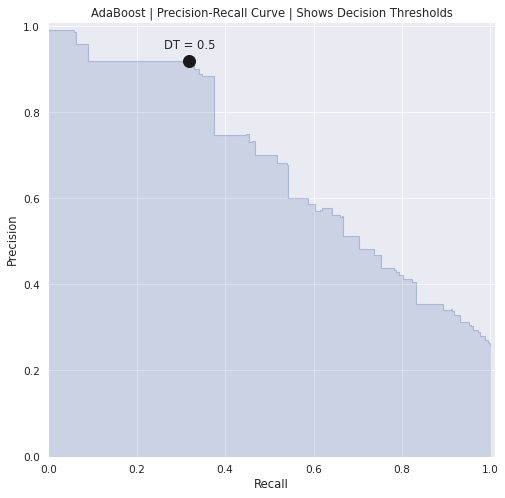

In [115]:
# generate Decision Tree predict probabilities; store precision-recall curve values
y_hat_prob_test3 = best_model_ab.predict_proba(X_test)[:, 1]
p3, r3, thresholds3 = precision_recall_curve(y_test, y_hat_prob_test3)

# plot precision-recall curve for baseline decision threshold 0.5
plot_pr_curve(p3, r3, thresholds3, 'AdaBoost', dt=[0.5])

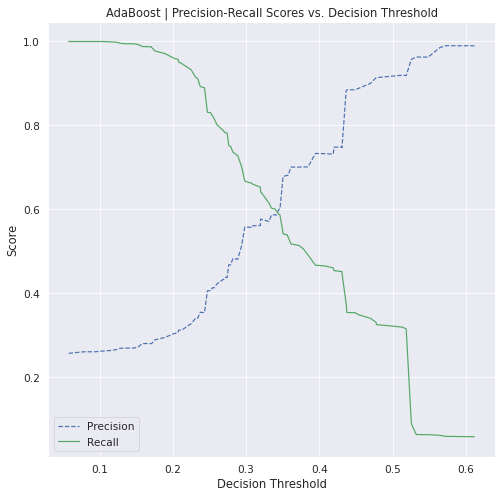

In [116]:
# plot precision and recall against decision threshold options
plot_pr_vs_dt(p3, r3, thresholds3, 'AdaBoost')

## Gradient Boost (m4)

In [81]:
# create Gradient Boost classifier object
model_gb = GradientBoostingClassifier(random_state=SEED)

In [85]:
# define the grid for Gradient Boost
grid_params_gb = [{'n_estimators': [25, 100],
                   'learning_rate': [0.01, 0.1, 1],
                   'max_depth': [3, 5, 8],
                   'min_samples_leaf': [10] # samples required in each leaf                   
                  }]

In [86]:
# create gridsearchCV object for Gradient Boost
gs_gb = instantiate_grid(model_gb, grid_params_gb)

In [87]:
# execute the Gradient Boost gridsearchCV on training data
gs_gb.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=10, n_estimators=25; accuracy: (test=0.849) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.500) total time=   5.5s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=10, n_estimators=25; accuracy: (test=0.849) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.500) total time=   5.5s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=10, n_estimators=25; accuracy: (test=0.849) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.500) total time=   5.5s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=10, n_estimators=25; accuracy: (test=0.849) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.500) total time=   5.5s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=10, n_estimators=25; accuracy: (test=0.849) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.500) total time=   5.5s
[CV 1/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=10, n_estimators=100; accuracy: (test=0.909) f1: (test=0.596) precision: (test=0.899) recall: (test=0.446) roc_auc: (test=0.718) total time=  21.8s
[CV 2/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=10, n_estimators=100; accuracy: (test=0.910) f1: (test=0.600) precision: (test=0.909) recall: (test=0.448) roc_auc: (test=0.720) total time=  21.9s
[CV 3/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=10, n_estimators=100; accuracy: (test=0.911) f1: (test=0.610) precision: (test=0.902) recall: (test=0.461) roc_auc: (test=0.726) total time=  21.8s
[CV 4/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=10, n_estimators=100; accuracy: (test=0.912) f1: (test=0.611) precision: (test=0.910) recall: 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END learning_rate=0.01, max_depth=5, min_samples_leaf=10, n_estimators=25; accuracy: (test=0.849) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.500) total time=   9.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END learning_rate=0.01, max_depth=5, min_samples_leaf=10, n_estimators=25; accuracy: (test=0.849) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.500) total time=   8.9s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END learning_rate=0.01, max_depth=5, min_samples_leaf=10, n_estimators=25; accuracy: (test=0.849) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.500) total time=   9.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END learning_rate=0.01, max_depth=5, min_samples_leaf=10, n_estimators=25; accuracy: (test=0.849) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.500) total time=   9.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END learning_rate=0.01, max_depth=5, min_samples_leaf=10, n_estimators=25; accuracy: (test=0.849) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.500) total time=   9.0s
[CV 1/5] END learning_rate=0.01, max_depth=5, min_samples_leaf=10, n_estimators=100; accuracy: (test=0.910) f1: (test=0.599) precision: (test=0.910) recall: (test=0.446) roc_auc: (test=0.719) total time=  35.7s
[CV 2/5] END learning_rate=0.01, max_depth=5, min_samples_leaf=10, n_estimators=100; accuracy: (test=0.913) f1: (test=0.615) precision: (test=0.916) recall: (test=0.463) roc_auc: (test=0.728) total time=  35.8s
[CV 3/5] END learning_rate=0.01, max_depth=5, min_samples_leaf=10, n_estimators=100; accuracy: (test=0.911) f1: (test=0.611) precision: (test=0.904) recall: (test=0.461) roc_auc: (test=0.726) total time=  35.9s
[CV 4/5] END learning_rate=0.01, max_depth=5, min_samples_leaf=10, n_estimators=100; accuracy: (test=0.913) f1: (test=0.619) precision: (test=0.913) recall: 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END learning_rate=0.01, max_depth=8, min_samples_leaf=10, n_estimators=25; accuracy: (test=0.849) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.500) total time=  12.7s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END learning_rate=0.01, max_depth=8, min_samples_leaf=10, n_estimators=25; accuracy: (test=0.849) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.500) total time=  13.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END learning_rate=0.01, max_depth=8, min_samples_leaf=10, n_estimators=25; accuracy: (test=0.849) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.500) total time=  13.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END learning_rate=0.01, max_depth=8, min_samples_leaf=10, n_estimators=25; accuracy: (test=0.849) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.500) total time=  13.5s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END learning_rate=0.01, max_depth=8, min_samples_leaf=10, n_estimators=25; accuracy: (test=0.849) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.500) total time=  13.2s
[CV 1/5] END learning_rate=0.01, max_depth=8, min_samples_leaf=10, n_estimators=100; accuracy: (test=0.913) f1: (test=0.620) precision: (test=0.909) recall: (test=0.470) roc_auc: (test=0.731) total time=  53.2s
[CV 2/5] END learning_rate=0.01, max_depth=8, min_samples_leaf=10, n_estimators=100; accuracy: (test=0.915) f1: (test=0.633) precision: (test=0.909) recall: (test=0.486) roc_auc: (test=0.739) total time=  53.7s
[CV 3/5] END learning_rate=0.01, max_depth=8, min_samples_leaf=10, n_estimators=100; accuracy: (test=0.915) f1: (test=0.632) precision: (test=0.909) recall: (test=0.484) roc_auc: (test=0.738) total time=  54.8s
[CV 4/5] END learning_rate=0.01, max_depth=8, min_samples_leaf=10, n_estimators=100; accuracy: (test=0.916) f1: (test=0.640) precision: (test=0.911) recall: 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=19, shuffle=True),
             estimator=GradientBoostingClassifier(random_state=19),
             param_grid=[{'learning_rate': [0.01, 0.1, 1],
                          'max_depth': [3, 5, 8], 'min_samples_leaf': [10],
                          'n_estimators': [25, 100]}],
             refit='precision',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)},
             verbose=3)

Gradient Boost Confusion Matrix - Training Data


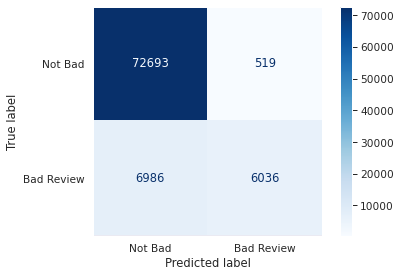

Best Model Parameters: 3 {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 100}


In [89]:
# print confusion matrix (train) for best model
best_model_gb = gs_gb.best_estimator_
print('Gradient Boost Confusion Matrix - Training Data')
display_confusion(best_model_gb, X_train, y_train, labels=['Not Bad', 'Bad Review'])
print(f'Best Model Parameters: {gs_gb.best_index_} {gs_gb.best_params_}')

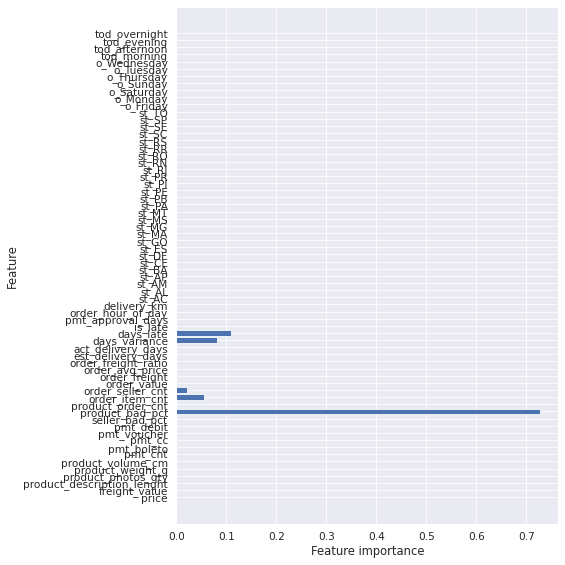

In [90]:
# plot Gradient Boost feature importance for best estimator
n_features = X_train.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), best_model_gb.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [91]:
# display top model results
cv_results4 = pd.DataFrame.from_dict(gs_gb.cv_results_)
cv_results_metrics4 = show_grid_metrics(cv_results4, 'mean_test_precision', top_n=5)

,params,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,rank_test_roc_auc,rank_test_recall
3,"{'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 100}",0.73,0.91,0.91,0.46,0.61,14,14
5,"{'learning_rate': 0.01, 'max_depth': 8, 'min_samples_leaf': 10, 'n_estimators': 100}",0.74,0.92,0.91,0.48,0.63,13,13
1,"{'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 10, 'n_estimators': 100}",0.72,0.91,0.91,0.45,0.60,15,15
10,"{'learning_rate': 0.1, 'max_depth': 8, 'min_samples_leaf': 10, 'n_estimators': 25}",0.78,0.92,0.86,0.57,0.69,9,10
6,"{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 10, 'n_estimators': 25}",0.76,0.92,0.86,0.53,0.66,12,12


In [92]:
# compare Gradient Boost metrics for Train vs Test data sets
print('Train Performance - Gradient Boost\n---------------------------------')
y_hat_train4 = gs_gb.predict(X_train)
scores_train_gb = score_pred('gb', 'train', y_train, y_hat_train4)

print('\nTest Performance - Gradient Boost\n--------------------------------')
y_hat_test4 = gs_gb.predict(X_test)
scores_test_gb = score_pred('gb', 'test', y_test, y_hat_test4)

Train Performance - Gradient Boost
---------------------------------
Model gb Predictions: AUC 0.73 | Accuracy 0.91 | Recall 0.46 | Precision 0.92 | F1 0.62

Test Performance - Gradient Boost
--------------------------------
Model gb Predictions: AUC 0.72 | Accuracy 0.91 | Recall 0.44 | Precision 0.91 | F1 0.6


Gradient Boost Confusion Matrix - Test Data


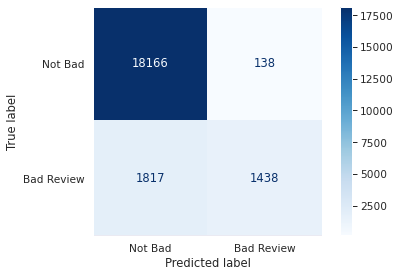

                   Not Bad Pred  Bad Review Pred
Not Bad Actual            18166              138
Bad Review Actual          1817             1438
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     18304
           1       0.91      0.44      0.60      3255

    accuracy                           0.91     21559
   macro avg       0.91      0.72      0.77     21559
weighted avg       0.91      0.91      0.90     21559



In [93]:
# print confusion matrix for best Gradient Boost model on Test data
print(f'Gradient Boost Confusion Matrix - Test Data')
display_confusion(best_model_gb, X_test, y_test, labels=['Not Bad', 'Bad Review'])
display_class_report(y_test, y_hat_test4)

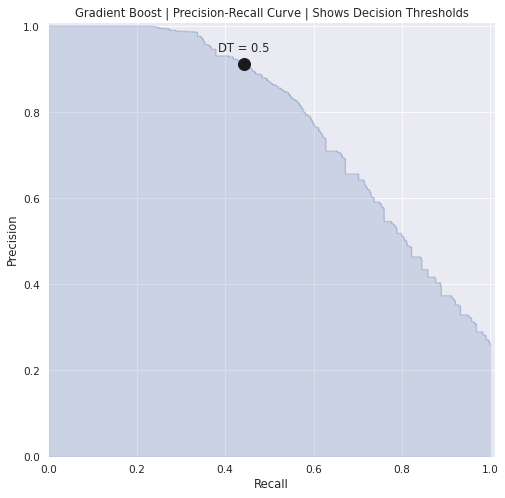

In [94]:
# generate Gradient Boost predict probabilities; store precision-recall curve values
y_hat_prob_test4 = best_model_gb.predict_proba(X_test)[:, 1]
p4, r4, thresholds4 = precision_recall_curve(y_test, y_hat_prob_test4)

# plot precision-recall curve for baseline decision threshold 0.5
plot_pr_curve(p4, r4, thresholds4, 'Gradient Boost', dt=[0.5])

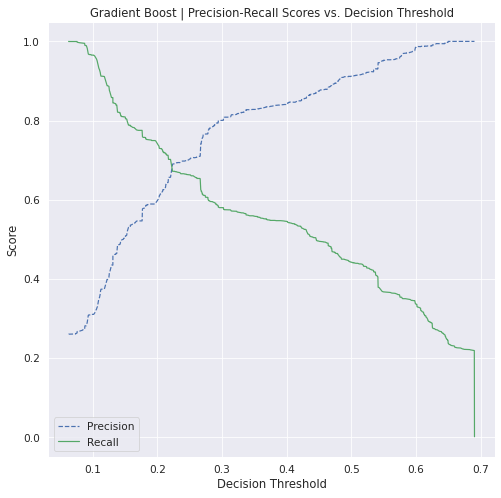

In [95]:
# plot precision and recall against decision threshold options
plot_pr_vs_dt(p4, r4, thresholds4, 'Gradient Boost')

## Logistic Regression (m5)

In [112]:
# create Logistic Regression classifier object
model_lr = LogisticRegression(random_state=SEED, n_jobs=jobs)

In [299]:
# define the grid for Logistic Regression
grid_params_lr = [{'penalty': ['l2'],
                   'C': [0.001, 0.01, 0.1, 1, 10, 1e10],
                   'class_weight' : ['balanced', None], 
                   'solver' : ['liblinear', 'saga']
                  }]

In [300]:
# create gridsearchCV object for Logistic Regression
gs_lr = instantiate_grid(model_lr, grid_params_lr)

In [301]:
# execute the Logistic Regression gridsearchCV on training data
gs_lr.fit(X_train_scaled_m5, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END C=0.001, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.855) f1: (test=0.619) precision: (test=0.512) recall: (test=0.782) roc_auc: (test=0.825) total time=   0.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 2/5] END C=0.001, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.855) f1: (test=0.623) precision: (test=0.513) recall: (test=0.791) roc_auc: (test=0.829) total time=   0.2s
[CV 3/5] END C=0.001, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.858) f1: (test=0.624) precision: (test=0.521) recall: (test=0.777) roc_auc: (test=0.825) total time=   0.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 4/5] END C=0.001, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.851) f1: (test=0.615) precision: (test=0.505) recall: (test=0.788) roc_auc: (test=0.825) total time=   0.2s
[CV 5/5] END C=0.001, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.859) f1: (test=0.630) precision: (test=0.522) recall: (test=0.794) roc_auc: (test=0.832) total time=   0.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 1/5] END C=0.001, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.860) f1: (test=0.624) precision: (test=0.525) recall: (test=0.769) roc_auc: (test=0.823) total time=   1.5s
[CV 2/5] END C=0.001, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.861) f1: (test=0.629) precision: (test=0.526) recall: (test=0.780) roc_auc: (test=0.828) total time=   0.8s
[CV 3/5] END C=0.001, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.863) f1: (test=0.629) precision: (test=0.533) recall: (test=0.768) roc_auc: (test=0.824) total time=   0.8s
[CV 4/5] END C=0.001, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.857) f1: (test=0.622) precision: (test=0.519) recall: (test=0.778) roc_auc: (test=0.825) total time=   0.8s
[CV 5/5] END C=0.001, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.865) f1: (test=0.636) precision: (test=0.536) recall: (test=0.783) roc_auc: (test=0.831) total time=   0.8s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 1/5] END C=0.001, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.907) f1: (test=0.624) precision: (test=0.803) recall: (test=0.510) roc_auc: (test=0.744) total time=   0.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 2/5] END C=0.001, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.909) f1: (test=0.639) precision: (test=0.801) recall: (test=0.531) roc_auc: (test=0.754) total time=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 3/5] END C=0.001, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.906) f1: (test=0.621) precision: (test=0.796) recall: (test=0.509) roc_auc: (test=0.743) total time=   0.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 4/5] END C=0.001, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.912) f1: (test=0.648) precision: (test=0.812) recall: (test=0.539) roc_auc: (test=0.759) total time=   0.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 5/5] END C=0.001, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.913) f1: (test=0.652) precision: (test=0.827) recall: (test=0.538) roc_auc: (test=0.759) total time=   0.2s
[CV 1/5] END C=0.001, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.906) f1: (test=0.602) precision: (test=0.829) recall: (test=0.472) roc_auc: (test=0.728) total time=   0.8s
[CV 2/5] END C=0.001, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.909) f1: (test=0.625) precision: (test=0.832) recall: (test=0.500) roc_auc: (test=0.741) total time=   0.8s
[CV 3/5] END C=0.001, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.906) f1: (test=0.608) precision: (test=0.823) recall: (test=0.483) roc_auc: (test=0.732) total time=   0.8s
[CV 4/5] END C=0.001, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.911) f1: (test=0.634) precision: (test=0.839) recall: (test=0.509) roc_auc: (test=0.746) total time=   0.8s
[CV 5/5] END C=0.001, class_weight=

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 1/5] END C=0.01, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.855) f1: (test=0.622) precision: (test=0.514) recall: (test=0.788) roc_auc: (test=0.828) total time=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 2/5] END C=0.01, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.858) f1: (test=0.627) precision: (test=0.519) recall: (test=0.793) roc_auc: (test=0.831) total time=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 3/5] END C=0.01, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.859) f1: (test=0.626) precision: (test=0.523) recall: (test=0.780) roc_auc: (test=0.827) total time=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 4/5] END C=0.01, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.852) f1: (test=0.618) precision: (test=0.507) recall: (test=0.791) roc_auc: (test=0.827) total time=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 5/5] END C=0.01, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.859) f1: (test=0.631) precision: (test=0.523) recall: (test=0.796) roc_auc: (test=0.833) total time=   0.3s
[CV 1/5] END C=0.01, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.856) f1: (test=0.622) precision: (test=0.515) recall: (test=0.786) roc_auc: (test=0.827) total time=   1.1s
[CV 2/5] END C=0.01, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.858) f1: (test=0.628) precision: (test=0.520) recall: (test=0.792) roc_auc: (test=0.831) total time=   0.9s
[CV 3/5] END C=0.01, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.860) f1: (test=0.626) precision: (test=0.524) recall: (test=0.778) roc_auc: (test=0.826) total time=   1.0s
[CV 4/5] END C=0.01, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.853) f1: (test=0.619) precision: (test=0.508) recall: (test=0.791) roc_auc: (test=0.827) total time=   1.0s
[CV 5/5] END C=0.01,

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 1/5] END C=0.01, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.907) f1: (test=0.625) precision: (test=0.794) recall: (test=0.516) roc_auc: (test=0.746) total time=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 2/5] END C=0.01, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.909) f1: (test=0.641) precision: (test=0.788) recall: (test=0.540) roc_auc: (test=0.757) total time=   0.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 3/5] END C=0.01, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.905) f1: (test=0.622) precision: (test=0.783) recall: (test=0.517) roc_auc: (test=0.746) total time=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 4/5] END C=0.01, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.911) f1: (test=0.649) precision: (test=0.801) recall: (test=0.545) roc_auc: (test=0.761) total time=   0.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 5/5] END C=0.01, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.913) f1: (test=0.655) precision: (test=0.816) recall: (test=0.546) roc_auc: (test=0.762) total time=   0.3s
[CV 1/5] END C=0.01, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.907) f1: (test=0.624) precision: (test=0.797) recall: (test=0.512) roc_auc: (test=0.745) total time=   1.1s
[CV 2/5] END C=0.01, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.908) f1: (test=0.639) precision: (test=0.790) recall: (test=0.536) roc_auc: (test=0.755) total time=   1.1s
[CV 3/5] END C=0.01, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.905) f1: (test=0.621) precision: (test=0.787) recall: (test=0.513) roc_auc: (test=0.744) total time=   1.1s
[CV 4/5] END C=0.01, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.911) f1: (test=0.647) precision: (test=0.805) recall: (test=0.541) roc_auc: (test=0.759) total time=   1.1s
[CV 5/5] END C=0.01, class_weight=None, 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 1/5] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.855) f1: (test=0.622) precision: (test=0.513) recall: (test=0.788) roc_auc: (test=0.828) total time=   0.2s
[CV 2/5] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.858) f1: (test=0.628) precision: (test=0.519) recall: (test=0.794) roc_auc: (test=0.831) total time=   0.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 3/5] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.859) f1: (test=0.626) precision: (test=0.523) recall: (test=0.779) roc_auc: (test=0.826) total time=   0.2s
[CV 4/5] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.852) f1: (test=0.618) precision: (test=0.507) recall: (test=0.791) roc_auc: (test=0.827) total time=   0.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 5/5] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.859) f1: (test=0.631) precision: (test=0.522) recall: (test=0.796) roc_auc: (test=0.833) total time=   0.2s
[CV 1/5] END C=0.1, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.855) f1: (test=0.622) precision: (test=0.514) recall: (test=0.788) roc_auc: (test=0.828) total time=   1.1s
[CV 2/5] END C=0.1, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.858) f1: (test=0.628) precision: (test=0.519) recall: (test=0.794) roc_auc: (test=0.831) total time=   1.0s
[CV 3/5] END C=0.1, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.859) f1: (test=0.626) precision: (test=0.523) recall: (test=0.779) roc_auc: (test=0.826) total time=   1.1s
[CV 4/5] END C=0.1, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.852) f1: (test=0.618) precision: (test=0.507) recall: (test=0.791) roc_auc: (test=0.827) total time=   1.1s
[CV 5/5] END C=0.1, class

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 1/5] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.906) f1: (test=0.625) precision: (test=0.791) recall: (test=0.517) roc_auc: (test=0.746) total time=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 2/5] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.908) f1: (test=0.639) precision: (test=0.785) recall: (test=0.539) roc_auc: (test=0.756) total time=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 3/5] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.905) f1: (test=0.623) precision: (test=0.779) recall: (test=0.519) roc_auc: (test=0.747) total time=   0.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 4/5] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.910) f1: (test=0.647) precision: (test=0.798) recall: (test=0.544) roc_auc: (test=0.760) total time=   0.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 5/5] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.913) f1: (test=0.654) precision: (test=0.812) recall: (test=0.548) roc_auc: (test=0.763) total time=   0.3s
[CV 1/5] END C=0.1, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.906) f1: (test=0.625) precision: (test=0.791) recall: (test=0.517) roc_auc: (test=0.746) total time=   1.3s
[CV 2/5] END C=0.1, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.908) f1: (test=0.639) precision: (test=0.785) recall: (test=0.539) roc_auc: (test=0.756) total time=   1.3s
[CV 3/5] END C=0.1, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.905) f1: (test=0.623) precision: (test=0.779) recall: (test=0.519) roc_auc: (test=0.746) total time=   1.2s
[CV 4/5] END C=0.1, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.910) f1: (test=0.647) precision: (test=0.798) recall: (test=0.544) roc_auc: (test=0.760) total time=   1.2s
[CV 5/5] END C=0.1, class_weight=None, penalt

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 1/5] END C=1, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.855) f1: (test=0.622) precision: (test=0.513) recall: (test=0.788) roc_auc: (test=0.828) total time=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 2/5] END C=1, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.858) f1: (test=0.628) precision: (test=0.519) recall: (test=0.794) roc_auc: (test=0.831) total time=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 3/5] END C=1, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.859) f1: (test=0.626) precision: (test=0.523) recall: (test=0.779) roc_auc: (test=0.826) total time=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 4/5] END C=1, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.852) f1: (test=0.618) precision: (test=0.507) recall: (test=0.791) roc_auc: (test=0.827) total time=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 5/5] END C=1, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.859) f1: (test=0.631) precision: (test=0.522) recall: (test=0.796) roc_auc: (test=0.833) total time=   0.3s
[CV 1/5] END C=1, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.855) f1: (test=0.622) precision: (test=0.513) recall: (test=0.788) roc_auc: (test=0.828) total time=   1.2s
[CV 2/5] END C=1, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.858) f1: (test=0.628) precision: (test=0.519) recall: (test=0.794) roc_auc: (test=0.831) total time=   1.1s
[CV 3/5] END C=1, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.859) f1: (test=0.626) precision: (test=0.523) recall: (test=0.779) roc_auc: (test=0.826) total time=   1.2s
[CV 4/5] END C=1, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.852) f1: (test=0.618) precision: (test=0.507) recall: (test=0.791) roc_auc: (test=0.827) total time=   1.2s
[CV 5/5] END C=1, class_weight=bala

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 1/5] END C=1, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.906) f1: (test=0.625) precision: (test=0.791) recall: (test=0.517) roc_auc: (test=0.746) total time=   0.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 2/5] END C=1, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.908) f1: (test=0.639) precision: (test=0.784) recall: (test=0.539) roc_auc: (test=0.756) total time=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 3/5] END C=1, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.905) f1: (test=0.623) precision: (test=0.778) recall: (test=0.519) roc_auc: (test=0.747) total time=   0.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 4/5] END C=1, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.910) f1: (test=0.647) precision: (test=0.798) recall: (test=0.544) roc_auc: (test=0.760) total time=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 5/5] END C=1, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.913) f1: (test=0.654) precision: (test=0.812) recall: (test=0.548) roc_auc: (test=0.763) total time=   0.3s
[CV 1/5] END C=1, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.906) f1: (test=0.625) precision: (test=0.791) recall: (test=0.517) roc_auc: (test=0.746) total time=   1.3s
[CV 2/5] END C=1, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.908) f1: (test=0.639) precision: (test=0.785) recall: (test=0.539) roc_auc: (test=0.756) total time=   1.3s
[CV 3/5] END C=1, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.905) f1: (test=0.623) precision: (test=0.778) recall: (test=0.519) roc_auc: (test=0.747) total time=   1.3s
[CV 4/5] END C=1, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.910) f1: (test=0.647) precision: (test=0.798) recall: (test=0.544) roc_auc: (test=0.760) total time=   1.3s
[CV 5/5] END C=1, class_weight=None, penalty=l2, solver

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 1/5] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.855) f1: (test=0.622) precision: (test=0.513) recall: (test=0.788) roc_auc: (test=0.828) total time=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 2/5] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.858) f1: (test=0.628) precision: (test=0.519) recall: (test=0.794) roc_auc: (test=0.831) total time=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 3/5] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.859) f1: (test=0.626) precision: (test=0.523) recall: (test=0.779) roc_auc: (test=0.826) total time=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 4/5] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.852) f1: (test=0.618) precision: (test=0.507) recall: (test=0.791) roc_auc: (test=0.827) total time=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 5/5] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.859) f1: (test=0.631) precision: (test=0.522) recall: (test=0.796) roc_auc: (test=0.833) total time=   0.3s
[CV 1/5] END C=10, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.855) f1: (test=0.622) precision: (test=0.513) recall: (test=0.788) roc_auc: (test=0.828) total time=   1.2s
[CV 2/5] END C=10, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.858) f1: (test=0.628) precision: (test=0.519) recall: (test=0.794) roc_auc: (test=0.831) total time=   1.1s
[CV 3/5] END C=10, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.859) f1: (test=0.626) precision: (test=0.523) recall: (test=0.779) roc_auc: (test=0.826) total time=   1.2s
[CV 4/5] END C=10, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.852) f1: (test=0.618) precision: (test=0.507) recall: (test=0.791) roc_auc: (test=0.827) total time=   1.2s
[CV 5/5] END C=10, class_weigh

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 1/5] END C=10, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.906) f1: (test=0.625) precision: (test=0.791) recall: (test=0.517) roc_auc: (test=0.746) total time=   0.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 2/5] END C=10, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.908) f1: (test=0.639) precision: (test=0.784) recall: (test=0.539) roc_auc: (test=0.756) total time=   0.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 3/5] END C=10, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.905) f1: (test=0.623) precision: (test=0.778) recall: (test=0.519) roc_auc: (test=0.747) total time=   0.2s
[CV 4/5] END C=10, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.910) f1: (test=0.647) precision: (test=0.798) recall: (test=0.544) roc_auc: (test=0.760) total time=   0.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 5/5] END C=10, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.913) f1: (test=0.654) precision: (test=0.812) recall: (test=0.548) roc_auc: (test=0.763) total time=   0.2s
[CV 1/5] END C=10, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.906) f1: (test=0.625) precision: (test=0.791) recall: (test=0.517) roc_auc: (test=0.746) total time=   0.9s
[CV 2/5] END C=10, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.908) f1: (test=0.639) precision: (test=0.784) recall: (test=0.539) roc_auc: (test=0.756) total time=   1.3s
[CV 3/5] END C=10, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.905) f1: (test=0.623) precision: (test=0.778) recall: (test=0.519) roc_auc: (test=0.747) total time=   1.3s
[CV 4/5] END C=10, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.910) f1: (test=0.647) precision: (test=0.798) recall: (test=0.544) roc_auc: (test=0.760) total time=   1.2s
[CV 5/5] END C=10, class_weight=None, penalty=l2, 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 1/5] END C=10000000000.0, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.855) f1: (test=0.622) precision: (test=0.513) recall: (test=0.788) roc_auc: (test=0.828) total time=   0.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 2/5] END C=10000000000.0, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.858) f1: (test=0.628) precision: (test=0.519) recall: (test=0.794) roc_auc: (test=0.831) total time=   0.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 3/5] END C=10000000000.0, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.859) f1: (test=0.626) precision: (test=0.523) recall: (test=0.779) roc_auc: (test=0.826) total time=   0.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 4/5] END C=10000000000.0, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.852) f1: (test=0.618) precision: (test=0.507) recall: (test=0.791) roc_auc: (test=0.827) total time=   0.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 5/5] END C=10000000000.0, class_weight=balanced, penalty=l2, solver=liblinear; accuracy: (test=0.859) f1: (test=0.631) precision: (test=0.522) recall: (test=0.796) roc_auc: (test=0.833) total time=   0.2s
[CV 1/5] END C=10000000000.0, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.855) f1: (test=0.622) precision: (test=0.513) recall: (test=0.788) roc_auc: (test=0.828) total time=   1.2s
[CV 2/5] END C=10000000000.0, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.858) f1: (test=0.628) precision: (test=0.519) recall: (test=0.794) roc_auc: (test=0.831) total time=   1.0s
[CV 3/5] END C=10000000000.0, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.859) f1: (test=0.626) precision: (test=0.523) recall: (test=0.779) roc_auc: (test=0.826) total time=   1.2s
[CV 4/5] END C=10000000000.0, class_weight=balanced, penalty=l2, solver=saga; accuracy: (test=0.852) f1: (test=0.618) precision: (test=0.507) recall: (test=0.791) roc_auc: (test=0

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 2/5] END C=10000000000.0, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.908) f1: (test=0.639) precision: (test=0.784) recall: (test=0.539) roc_auc: (test=0.756) total time=   0.2s
[CV 3/5] END C=10000000000.0, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.905) f1: (test=0.623) precision: (test=0.778) recall: (test=0.519) roc_auc: (test=0.747) total time=   0.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 4/5] END C=10000000000.0, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.910) f1: (test=0.647) precision: (test=0.798) recall: (test=0.544) roc_auc: (test=0.760) total time=   0.2s
[CV 5/5] END C=10000000000.0, class_weight=None, penalty=l2, solver=liblinear; accuracy: (test=0.913) f1: (test=0.654) precision: (test=0.812) recall: (test=0.548) roc_auc: (test=0.763) total time=   0.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 72.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV 1/5] END C=10000000000.0, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.906) f1: (test=0.625) precision: (test=0.791) recall: (test=0.517) roc_auc: (test=0.746) total time=   1.5s
[CV 2/5] END C=10000000000.0, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.908) f1: (test=0.639) precision: (test=0.784) recall: (test=0.539) roc_auc: (test=0.756) total time=   1.3s
[CV 3/5] END C=10000000000.0, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.905) f1: (test=0.623) precision: (test=0.778) recall: (test=0.519) roc_auc: (test=0.747) total time=   1.3s
[CV 4/5] END C=10000000000.0, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.910) f1: (test=0.647) precision: (test=0.798) recall: (test=0.544) roc_auc: (test=0.760) total time=   1.2s
[CV 5/5] END C=10000000000.0, class_weight=None, penalty=l2, solver=saga; accuracy: (test=0.913) f1: (test=0.654) precision: (test=0.812) recall: (test=0.548) roc_auc: (test=0.763) total time=   1.3s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=19, shuffle=True),
             estimator=LogisticRegression(n_jobs=-1, random_state=19),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 10000000000.0],
                          'class_weight': ['balanced', None], 'penalty': ['l2'],
                          'solver': ['liblinear', 'saga']}],
             refit='precision',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)},
             verbose=3)

Logistic Regression Confusion Matrix - Training Data


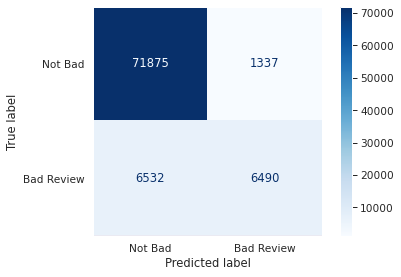

Best Model Parameters: 3 {'C': 0.001, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}


In [302]:
# print confusion matrix (train) for best model
best_model_lr = gs_lr.best_estimator_
print('Logistic Regression Confusion Matrix - Training Data')
display_confusion(best_model_lr, X_train_scaled_m5, y_train, labels=['Not Bad', 'Bad Review'])
print(f'Best Model Parameters: {gs_lr.best_index_} {gs_lr.best_params_}')

In [303]:
# display top model results
cv_results5 = pd.DataFrame.from_dict(gs_lr.cv_results_)
cv_results_metrics5 = show_grid_metrics(cv_results5, 'mean_test_precision', top_n=5)

,params,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,rank_test_roc_auc,rank_test_recall
3,"{'C': 0.001, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}",0.74,0.91,0.83,0.49,0.62,24,24
2,"{'C': 0.001, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}",0.75,0.91,0.81,0.53,0.64,23,23
7,"{'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}",0.75,0.91,0.80,0.53,0.64,22,22
6,"{'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}",0.75,0.91,0.80,0.53,0.64,21,21
10,"{'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}",0.75,0.91,0.79,0.53,0.64,19,19


In [304]:
# compare Logistic Regression metrics for Train vs Test data sets
print('Train Performance - Logistic Regression\n---------------------------------')
y_hat_train5 = gs_lr.predict(X_train_scaled_m5)
scores_train_lr = score_pred('lr', 'train', y_train, y_hat_train5)

print('\nTest Performance - Logistic Regression\n--------------------------------')
y_hat_test5 = gs_lr.predict(X_test_scaled_m5)
scores_test_lr = score_pred('lr', 'test', y_test, y_hat_test5)

Train Performance - Logistic Regression
---------------------------------
Model lr Predictions: AUC 0.74 | Accuracy 0.91 | Recall 0.5 | Precision 0.83 | F1 0.62

Test Performance - Logistic Regression
--------------------------------
Model lr Predictions: AUC 0.74 | Accuracy 0.91 | Recall 0.49 | Precision 0.83 | F1 0.61


Logistic Regression Confusion Matrix - Test Data


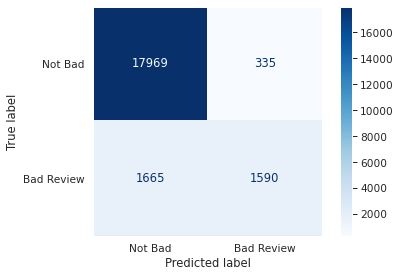

                   Not Bad Pred  Bad Review Pred
Not Bad Actual            17969              335
Bad Review Actual          1665             1590
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     18304
           1       0.83      0.49      0.61      3255

    accuracy                           0.91     21559
   macro avg       0.87      0.74      0.78     21559
weighted avg       0.90      0.91      0.90     21559



In [305]:
# print confusion matrix for best Logistic Regression model on Test data
print(f'Logistic Regression Confusion Matrix - Test Data')
display_confusion(best_model_lr, X_test_scaled_m5, y_test, labels=['Not Bad', 'Bad Review'])
display_class_report(y_test, y_hat_test5)

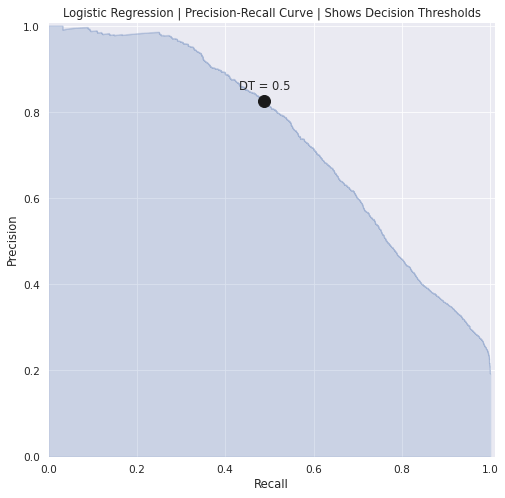

In [306]:
# generate Logistic Regression predict probabilities; store precision-recall curve values
y_hat_prob_test5 = best_model_lr.predict_proba(X_test_scaled_m5)[:, 1]
p5, r5, thresholds5 = precision_recall_curve(y_test, y_hat_prob_test5)

# plot precision-recall curve for baseline decision threshold 0.5
plot_pr_curve(p5, r5, thresholds5, 'Logistic Regression', dt=[0.5])

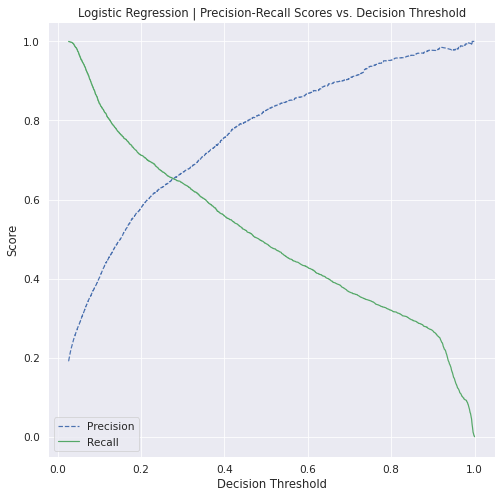

In [307]:
# plot precision and recall against decision threshold options
plot_pr_vs_dt(p5, r5, thresholds5, 'Logistic Regression')

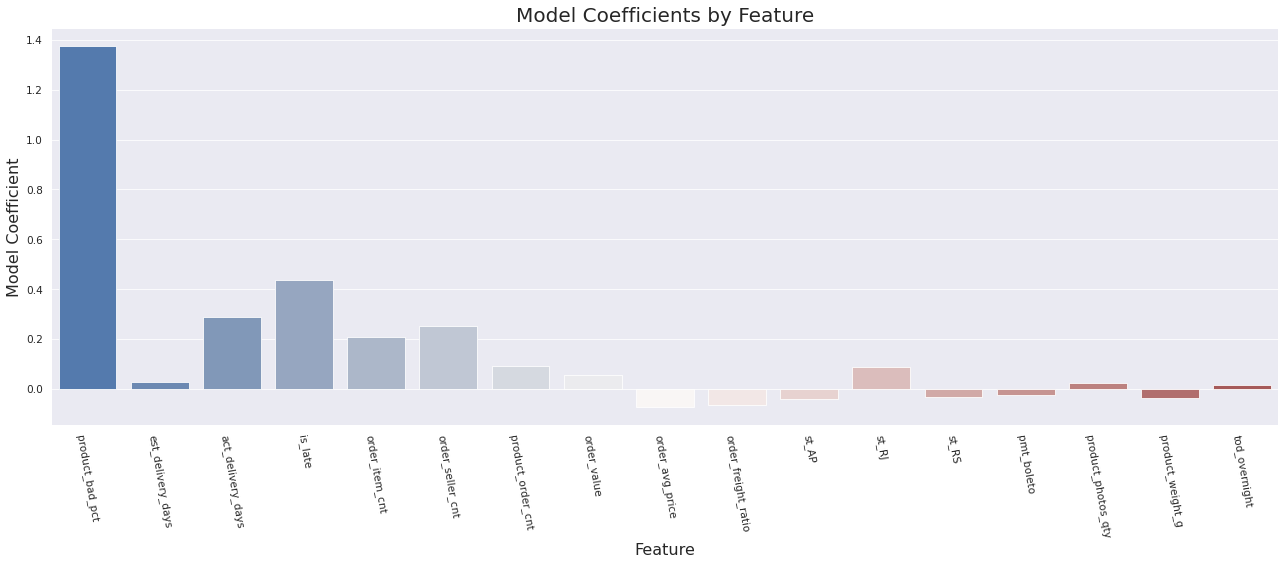

,feature,coef
0,product_bad_pct,1.38
1,est_delivery_days,0.03
2,act_delivery_days,0.29
3,is_late,0.44
4,order_item_cnt,0.21
5,order_seller_cnt,0.25
6,product_order_cnt,0.09
7,order_value,0.05
8,order_avg_price,-0.07
9,order_freight_ratio,-0.07


In [308]:
# plot Random Forest feature importance for best estimator
feature_importance(best_model_lr, X_train_scaled_m5)

In [292]:
X_train.columns

Index(['price', 'freight_value', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_volume_cm',
       'pmt_cnt', 'pmt_boleto', 'pmt_cc', 'pmt_voucher', 'pmt_debit',
       'seller_bad_pct', 'product_bad_pct', 'product_order_cnt',
       'order_item_cnt', 'order_seller_cnt', 'order_value', 'order_freight',
       'order_avg_price', 'order_freight_ratio', 'est_delivery_days',
       'act_delivery_days', 'days_variance', 'days_late', 'is_late',
       'pmt_approval_days', 'order_hour_of_day', 'delivery_km', 'st_AC',
       'st_AL', 'st_AM', 'st_AP', 'st_BA', 'st_CE', 'st_DF', 'st_ES', 'st_GO',
       'st_MA', 'st_MG', 'st_MS', 'st_MT', 'st_PA', 'st_PB', 'st_PE', 'st_PI',
       'st_PR', 'st_RJ', 'st_RN', 'st_RO', 'st_RR', 'st_RS', 'st_SC', 'st_SE',
       'st_SP', 'st_TO', 'o_Friday', 'o_Monday', 'o_Saturday', 'o_Sunday',
       'o_Thursday', 'o_Tuesday', 'o_Wednesday', 'tod_morning',
       'tod_afternoon', 'tod_evening', 'tod_overnight'],
      dtyp

In [297]:
cols_a = ['product_bad_pct', 'est_delivery_days', 'act_delivery_days', 'is_late', 
          'order_item_cnt', 'order_seller_cnt', 'product_order_cnt', 'order_value', 
          'order_avg_price', 'order_freight_ratio', 'st_AP', 'st_RJ', 
          'st_RS', 'pmt_boleto', 'product_photos_qty', 'product_weight_g', 'tod_overnight']
X_train_scaled_m5 = X_train_scaled[cols_a]
X_test_scaled_m5 = X_test_scaled[cols_a]

In [298]:
# Fit the training data
sm_lr = sm.Logit(y_train, sm.add_constant(X_train_scaled_m5)).fit()
print(sm_lr.summary())

Optimization terminated successfully.
         Current function value: 0.231913
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             review_bad   No. Observations:                86234
Model:                          Logit   Df Residuals:                    86216
Method:                           MLE   Df Model:                           17
Date:                Sat, 12 Jun 2021   Pseudo R-squ.:                  0.4536
Time:                        14:58:38   Log-Likelihood:                -19999.
converged:                       True   LL-Null:                       -36602.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.5139      0.016   -155.811      0.000      -2.546      -2.482
pr

## SGD Classifier (m6)

In [309]:
# create SGD Classifier classifier object
model_sgd = SGDClassifier(random_state=SEED, n_jobs=jobs)

In [317]:
# define the grid for SGD Classifier
grid_params_sgd = [{'max_iter': [250, 1000], 
                    'loss': ['log', 'hinge'],
                    'penalty': ['l2', None],
                    'alpha': [0.001, 0.01, 0.1], 
                    'class_weight': ['balanced', None]
                  }]

In [318]:
# create gridsearchCV object for SGD Classifier
gs_sgd = instantiate_grid(model_sgd, grid_params_sgd)

In [319]:
# execute the SGD Classifier gridsearchCV on training data
gs_sgd.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END alpha=0.001, class_weight=balanced, loss=log, max_iter=250, penalty=l2; accuracy: (test=0.857) f1: (test=0.624) precision: (test=0.517) recall: (test=0.785) roc_auc: (test=0.827) total time=   0.6s
[CV 2/5] END alpha=0.001, class_weight=balanced, loss=log, max_iter=250, penalty=l2; accuracy: (test=0.858) f1: (test=0.626) precision: (test=0.518) recall: (test=0.791) roc_auc: (test=0.830) total time=   0.6s
[CV 3/5] END alpha=0.001, class_weight=balanced, loss=log, max_iter=250, penalty=l2; accuracy: (test=0.856) f1: (test=0.621) precision: (test=0.515) recall: (test=0.782) roc_auc: (test=0.825) total time=   0.5s
[CV 4/5] END alpha=0.001, class_weight=balanced, loss=log, max_iter=250, penalty=l2; accuracy: (test=0.854) f1: (test=0.622) precision: (test=0.510) recall: (test=0.798) roc_auc: (test=0.831) total time=   0.7s
[CV 5/5] END alpha=0.001, class_weight=balanced, loss=log, max_iter=250, penalty=l2; accuracy:

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[CV 5/5] END alpha=0.01, class_weight=balanced, loss=log, max_iter=250, penalty=None; accuracy: (test=0.827) f1: (test=0.584) precision: (test=0.459) recall: (test=0.803) roc_auc: (test=0.817) total time=   6.8s
[CV 1/5] END alpha=0.01, class_weight=balanced, loss=log, max_iter=1000, penalty=l2; accuracy: (test=0.859) f1: (test=0.624) precision: (test=0.521) recall: (test=0.778) roc_auc: (test=0.825) total time=   0.3s
[CV 2/5] END alpha=0.01, class_weight=balanced, loss=log, max_iter=1000, penalty=l2; accuracy: (test=0.863) f1: (test=0.634) precision: (test=0.531) recall: (test=0.787) roc_auc: (test=0.832) total time=   0.3s
[CV 3/5] END alpha=0.01, class_weight=balanced, loss=log, max_iter=1000, penalty=l2; accuracy: (test=0.862) f1: (test=0.628) precision: (test=0.531) recall: (test=0.770) roc_auc: (test=0.824) total time=   0.4s
[CV 4/5] END alpha=0.01, class_weight=balanced, loss=log, max_iter=1000, penalty=l2; accuracy: (test=0.857) f1: (test=0.623) precision: (test=0.517) recall

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=19, shuffle=True),
             estimator=SGDClassifier(n_jobs=-1, random_state=19),
             param_grid=[{'alpha': [0.001, 0.01, 0.1, 1],
                          'class_weight': ['balanced', None],
                          'loss': ['log', 'hinge'], 'max_iter': [250, 1000],
                          'penalty': ['l2', None]}],
             refit='precision',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)},
             verbose=3)

SGD Classifier Confusion Matrix - Training Data


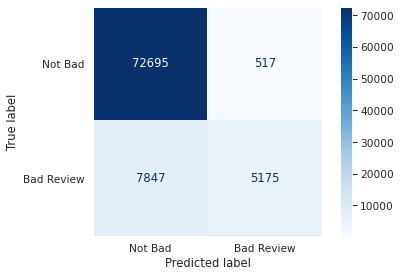

Best Model Parameters: 40 {'alpha': 0.1, 'class_weight': None, 'loss': 'log', 'max_iter': 250, 'penalty': 'l2'}


In [320]:
# print confusion matrix (train) for best model
best_model_sgd = gs_sgd.best_estimator_
print('SGD Classifier Confusion Matrix - Training Data')
display_confusion(best_model_sgd, X_train_scaled, y_train, labels=['Not Bad', 'Bad Review'])
print(f'Best Model Parameters: {gs_sgd.best_index_} {gs_sgd.best_params_}')

In [322]:
# display top model results
cv_results6 = pd.DataFrame.from_dict(gs_sgd.cv_results_)
cv_results_metrics6 = show_grid_metrics(cv_results6, 'mean_test_precision', top_n=5)

,params,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,rank_test_roc_auc,rank_test_recall
42,"{'alpha': 0.1, 'class_weight': None, 'loss': 'log', 'max_iter': 1000, 'penalty': 'l2'}",0.70,0.90,0.91,0.40,0.55,59,59
40,"{'alpha': 0.1, 'class_weight': None, 'loss': 'log', 'max_iter': 250, 'penalty': 'l2'}",0.70,0.90,0.91,0.40,0.55,59,59
62,"{'alpha': 1, 'class_weight': None, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2'}",0.52,0.85,0.89,0.04,0.08,61,61
60,"{'alpha': 1, 'class_weight': None, 'loss': 'hinge', 'max_iter': 250, 'penalty': 'l2'}",0.52,0.85,0.89,0.04,0.08,61,61
44,"{'alpha': 0.1, 'class_weight': None, 'loss': 'hinge', 'max_iter': 250, 'penalty': 'l2'}",0.72,0.91,0.88,0.44,0.59,57,57


In [323]:
# compare SGD Classifier metrics for Train vs Test data sets
print('Train Performance - SGD Classifier\n---------------------------------')
y_hat_train6 = gs_sgd.predict(X_train_scaled)
scores_train_sgd = score_pred('sgd', 'train', y_train, y_hat_train6)

print('\nTest Performance - SGD Classifier\n--------------------------------')
y_hat_test6 = gs_sgd.predict(X_test_scaled)
scores_test_sgd = score_pred('sgd', 'test', y_test, y_hat_test6)

Train Performance - SGD Classifier
---------------------------------
Model sgd Predictions: AUC 0.7 | Accuracy 0.9 | Recall 0.4 | Precision 0.91 | F1 0.55

Test Performance - SGD Classifier
--------------------------------
Model sgd Predictions: AUC 0.69 | Accuracy 0.9 | Recall 0.38 | Precision 0.9 | F1 0.53


SGD Classifier Confusion Matrix - Test Data


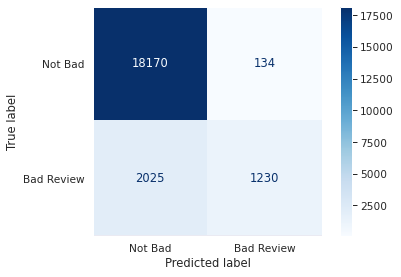

                   Not Bad Pred  Bad Review Pred
Not Bad Actual            18170              134
Bad Review Actual          2025             1230
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     18304
           1       0.90      0.38      0.53      3255

    accuracy                           0.90     21559
   macro avg       0.90      0.69      0.74     21559
weighted avg       0.90      0.90      0.88     21559



In [325]:
# print confusion matrix for best SGD Classifier model on Test data
print(f'SGD Classifier Confusion Matrix - Test Data')
display_confusion(best_model_sgd, X_test_scaled, y_test, labels=['Not Bad', 'Bad Review'])
display_class_report(y_test, y_hat_test6)

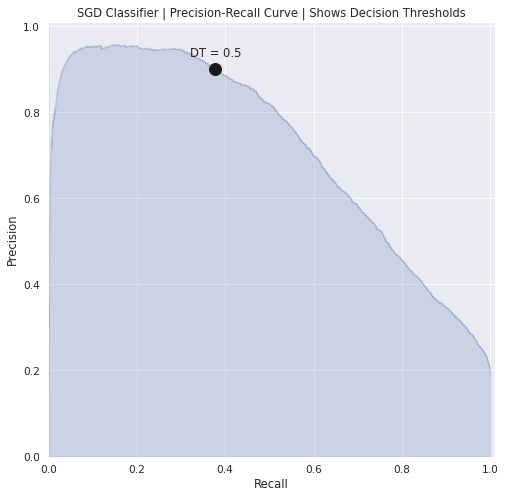

In [326]:
# generate SGD Classifier predict probabilities; store precision-recall curve values
y_hat_prob_test6 = best_model_sgd.predict_proba(X_test_scaled)[:, 1]
p6, r6, thresholds6 = precision_recall_curve(y_test, y_hat_prob_test6)

# plot precision-recall curve for baseline decision threshold 0.5
plot_pr_curve(p6, r6, thresholds6, 'SGD Classifier', dt=[0.5])

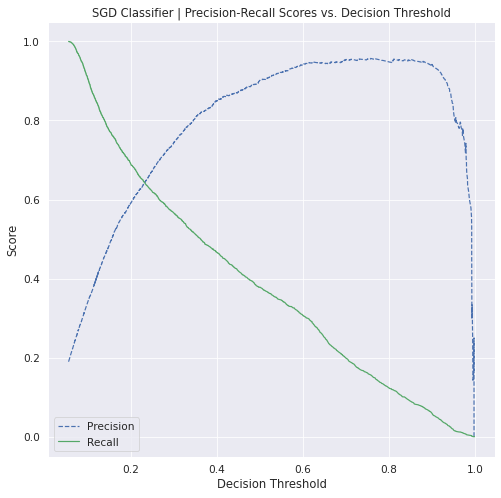

In [327]:
# plot precision and recall against decision threshold options
plot_pr_vs_dt(p6, r6, thresholds6, 'SGD Classifier')

## Gaussian Naive Bayes (m7)

In [330]:
# create GaussianNB classifier object
model_gnb = GaussianNB()

In [331]:
# define the grid for GaussianNB
grid_params_gnb = [{'var_smoothing': np.logspace(0,-9, num=100)
                  }]

In [332]:
# create gridsearchCV object for GaussianNB
gs_gnb = instantiate_grid(model_gnb, grid_params_gnb)

In [345]:
# execute the GaussianNB gridsearchCV on training data
gs_gnb.fit(X_train_scaled_m5, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END var_smoothing=1.0; accuracy: (test=0.889) f1: (test=0.569) precision: (test=0.688) recall: (test=0.485) roc_auc: (test=0.723) total time=   0.0s
[CV 2/5] END var_smoothing=1.0; accuracy: (test=0.890) f1: (test=0.576) precision: (test=0.689) recall: (test=0.494) roc_auc: (test=0.727) total time=   0.0s
[CV 3/5] END var_smoothing=1.0; accuracy: (test=0.889) f1: (test=0.560) precision: (test=0.701) recall: (test=0.466) roc_auc: (test=0.715) total time=   0.0s
[CV 4/5] END var_smoothing=1.0; accuracy: (test=0.891) f1: (test=0.584) precision: (test=0.687) recall: (test=0.509) roc_auc: (test=0.734) total time=   0.0s
[CV 5/5] END var_smoothing=1.0; accuracy: (test=0.893) f1: (test=0.581) precision: (test=0.714) recall: (test=0.489) roc_auc: (test=0.727) total time=   0.0s
[CV 1/5] END var_smoothing=0.8111308307896871; accuracy: (test=0.887) f1: (test=0.579) precision: (test=0.660) recall: (test=0.515) roc_auc: (test=

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=19, shuffle=True),
             estimator=GaussianNB(),
             param_grid=[{'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.336699...
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])}],
             refit='precision',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)},
             verbose=3)

GaussianNB Confusion Matrix - Training Data


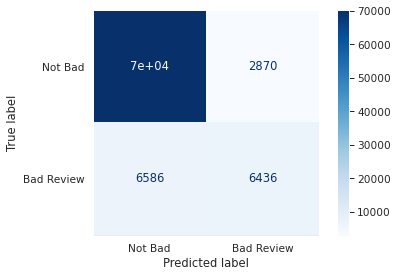

Best Model Parameters: 0 {'var_smoothing': 1.0}


In [347]:
# print confusion matrix (train) for best model
best_model_gnb = gs_gnb.best_estimator_
print('GaussianNB Confusion Matrix - Training Data')
display_confusion(best_model_gnb, X_train_scaled_m5, y_train, labels=['Not Bad', 'Bad Review'])
print(f'Best Model Parameters: {gs_gnb.best_index_} {gs_gnb.best_params_}')

In [348]:
# display top model results
cv_results7 = pd.DataFrame.from_dict(gs_gnb.cv_results_)
cv_results_metrics7 = show_grid_metrics(cv_results7, 'mean_test_precision', top_n=5)

,params,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,rank_test_roc_auc,rank_test_recall
0,{'var_smoothing': 1.0},0.73,0.89,0.70,0.49,0.57,100,100
1,{'var_smoothing': 0.8111308307896871},0.74,0.89,0.67,0.52,0.59,99,99
2,{'var_smoothing': 0.657933224657568},0.75,0.89,0.65,0.54,0.59,98,98
3,{'var_smoothing': 0.533669923120631},0.75,0.88,0.62,0.56,0.59,97,97
4,{'var_smoothing': 0.43287612810830584},0.75,0.88,0.61,0.57,0.59,96,96


In [349]:
# compare GaussianNB metrics for Train vs Test data sets
print('Train Performance - GaussianNB\n---------------------------------')
y_hat_train7 = gs_gnb.predict(X_train_scaled_m5)
scores_train_gs_gnb = score_pred('gnb', 'train', y_train, y_hat_train7)

print('\nTest Performance - GaussianNB\n--------------------------------')
y_hat_test7 = gs_gnb.predict(X_test_scaled_m5)
scores_test_gs_gnb = score_pred('gnb', 'test', y_test, y_hat_test7)

Train Performance - GaussianNB
---------------------------------
Model gnb Predictions: AUC 0.73 | Accuracy 0.89 | Recall 0.49 | Precision 0.69 | F1 0.58

Test Performance - GaussianNB
--------------------------------
Model gnb Predictions: AUC 0.72 | Accuracy 0.89 | Recall 0.48 | Precision 0.67 | F1 0.56


GaussianNB Confusion Matrix - Test Data


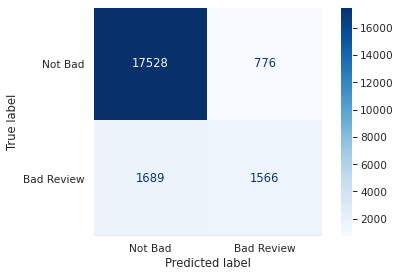

                   Not Bad Pred  Bad Review Pred
Not Bad Actual            17528              776
Bad Review Actual          1689             1566
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     18304
           1       0.67      0.48      0.56      3255

    accuracy                           0.89     21559
   macro avg       0.79      0.72      0.75     21559
weighted avg       0.88      0.89      0.88     21559



In [350]:
# print confusion matrix for best GaussianNB model on Test data
print(f'GaussianNB Confusion Matrix - Test Data')
display_confusion(best_model_gnb, X_test_scaled_m5, y_test, labels=['Not Bad', 'Bad Review'])
display_class_report(y_test, y_hat_test7)

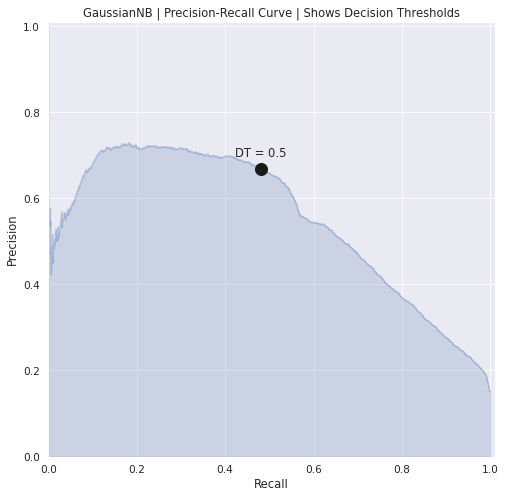

In [351]:
# generate GaussianNB predict probabilities; store precision-recall curve values
y_hat_prob_test7 = best_model_gnb.predict_proba(X_test_scaled_m5)[:, 1]
p7, r7, thresholds7 = precision_recall_curve(y_test, y_hat_prob_test7)

# plot precision-recall curve for baseline decision threshold 0.5
plot_pr_curve(p7, r7, thresholds7, 'GaussianNB', dt=[0.5])

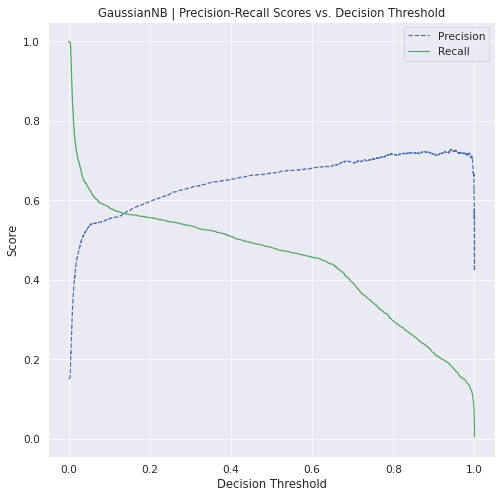

In [352]:
# plot precision and recall against decision threshold options
plot_pr_vs_dt(p7, r7, thresholds7, 'GaussianNB')

## Compare Models

In [ ]:
# export test scores to csv format for Tableau
import csv
toCSV = [scores_test_dum, scores_test_rf, scores_test_ab, scores_test_gb, scores_test_lr, scores_test_sgd, scores_test_gs_gnb]
with open('p05_scores_comb.csv', 'w', encoding='utf8', newline='') as output_file:
    fc = csv.DictWriter(output_file, 
                        fieldnames=toCSV[0].keys(),
                       )
    fc.writeheader()
    fc.writerows(toCSV)

In [100]:
scores_test_sgd

NameError: name 'scores_test_sgd' is not defined